In [6]:
import imaging_behavior_functions_cleaned
import imaging_behavior_functions_plotting
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import re
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.stats import circmean
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib as mpl
import pickle
from scipy.stats import sem
import copy



Notes:
filter out criteria:
- fragemented path (lots of stop start)
- very biasded heading, not able to cover the full 2pi
- pathes that look hard to determine the modal heading
- chronic drifting baseline

filtered out trials:
- 20220525-5_MBON09_GCAMP7f_fly2 trial 2 (okay)
- 20220621-2_MBON09_GCAMP7f_short trial 1 & 2
- 20220913-8_MBON09hDeltaB_syntGCAMP7f_fly3_short trial 1
- 0220913-9_MBON09hDeltaB_syntGCAMP7f_fly3_long trial 1 
- 20221011-3_hDeltaBMBON09_syntGCAMP7f_odor trial 4
- 20230426-8_MBON09hDeltaB_syntGCAMP7f_long_nojump_fly4 no MBON09 ROI
- 20230511-2_MBON09hDeltaB_syntGCAMP7f_long_nojump 1 & 2 & 3
- 20230511-3_MBON09hDeltaB_syntGCAMP7f_long_jump 1 & 2
- 20230517-2_MBON09hDeltaB_syntGCAMP7f_long_nojump trial 2
- 20230517-7_MBON09_syntGCAMP7f_fly2_long_jump trial 2
- 20230529-3_MBON09_hDeltaB_syntGCAMP7f_odor 2 & 3
- 20230608-5_MBON09hDeltaB_GCAMP7f_odor_short_benzylad 1
- 20230710-1_MBON09_GCAMP7f_odor_apple_width30 2
- 20230714-1_MBON09hDeltaB_syntGCAMP7f_odor_apple_width10_long 1 & 2
- 20230725-1_MBON09_GCAMP7f_odor_apple_sparsegrid 1 ?
- 20230726-1_MBON09_GCAMP7f_odor_apple_sparsegrid 1 & 2 & 3
- 20230726-2_MBON09_GCAMP7f_odor_apple_densegrid 1 & 2
- 20230901-2_MBON09hDeltaB_syntGCAMP7f_apple_sigmoid_flipaxis 1
- 20230901-3_MBON09hDeltaB_syntGCAMP7f_apple_sigmoid_flipaxis_flipsign 1
- 20230919-5_MBON09hDeltaB_syntGCAMP7f_test_sigmoid [processing error check again]
- 20230927-4_MBON09hDeltaB_syntGCAMP7f_10secodor_30isi 1
- 20230927-6_MBON09hDeltaB_syntGCAMP7f_20secodor_40isi 1 & 2
- 20230928-1_MBON09hDeltaB_syntGCAMP7f_10secodor_30isi 1
- 20230928-2_MBON09hDeltaB_syntGCAMP7f_50secodor_100isi 1

#### Shared processing functions

In [10]:

def plot_neural_activity_zero(df, pre_window_size, post_window_size, 
                                plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"],
                                sigma=None, plot_kw='past_interval', is_onset=True, 
                                bounds=[10, 25, 100, 200], percentile_range=[0, 100],
                                baseline_duration=1,onset_shift=0.6):
    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")

    if "time" not in df.columns:
        raise ValueError("Column 'time' not found in the dataframe.")

    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_filter1d(df[column], sigma)

    odor_onsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 0) & (df["odor_state"] == 1)]
    odor_offsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 1) & (df["odor_state"] == 0)]

    fig, axs = plt.subplots(len(plot_columns) // 2, 2, figsize=(12, 2 * len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces = []
        trace_colors = []
        
        column = f"{column}_smoothed" if sigma else column

        for j in range(len(odor_onsets) - 1):
            onset = odor_onsets[j]
            offset = odor_offsets[j]
            
            if is_onset:
                start = max(0, onset - pre_window_size)
                end = min(len(df), onset + post_window_size)
                time_ref = onset
            else:
                start = max(0, offset - pre_window_size)
                end = min(len(df), offset + post_window_size)
                time_ref = offset
            
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[time_ref]
            # Shift time axis for plotting so that odor onset appears at onset_shift seconds
            time_trace = time_trace + onset_shift
            time_trace = time_trace.reset_index(drop=True)

            if np.array(time_trace)[-1] > 0 and np.array(time_trace)[0] < 0:
                # Baseline subtraction: subtract the mean of the fixed prestimulus period 
                # (only using points within the last `baseline_duration` seconds before time zero)
                baseline = trace[(time_trace < 0) & (time_trace >= -baseline_duration)].mean()
                trace = trace - baseline
                
                aligned_traces.append((time_trace, trace))
                if is_onset:
                    value = df.loc[onset, plot_kw]
                else:
                    value = df.loc[offset, plot_kw]
                if value is not None:
                    trace_colors.append(value)
        
        if trace_colors:
            lower_bound, upper_bound = np.percentile(trace_colors, percentile_range)
            norm = plt.Normalize(max(min(trace_colors), lower_bound), min(max(trace_colors), upper_bound))
            cmap = plt.cm.gray
        #for idx, (time_trace, trace) in enumerate(aligned_traces):
            #color = cmap(norm(trace_colors[idx])) if trace_colors else "blue"
            #axs[i].plot(time_trace, trace, alpha=0.1, color=color)
        grouped_traces = {str(idx): [] for idx in range(len(bounds) + 1)}
        
        for idx, value in enumerate(trace_colors):
            if value < bounds[0]:
                grouped_traces["0"].append(aligned_traces[idx][1])
            else:
                for b_idx in range(1, len(bounds)):
                    if bounds[b_idx - 1] <= value < bounds[b_idx]:
                        grouped_traces[str(b_idx)].append(aligned_traces[idx][1])
                        break
                else:
                    grouped_traces[str(len(bounds))].append(aligned_traces[idx][1])
        
        for group, traces in grouped_traces.items():
            if traces:
                trace_df = pd.DataFrame(traces)
                mean_trace = trace_df.mean()
                stderr = trace_df.std() / np.sqrt(len(traces))
                mean_time = pd.Series([-pre_window_size + i for i in range(pre_window_size + post_window_size)])
                
                group_values = [trace_colors[idx] for idx, value in enumerate(trace_colors)
                                if (value < bounds[0] and group == "0") or
                                any(bounds[b_idx - 1] <= value < bounds[b_idx] and group == str(b_idx) for b_idx in range(1, len(bounds))) or
                                (value >= bounds[-1] and group == str(len(bounds)))]
                
                if group_values:
                    group_avg = np.mean(group_values)
                    color = cmap(norm(group_avg))
                    axs[i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")
                    axs[i].fill_between(time_trace, mean_trace - stderr, mean_trace + stderr, 
                                          color=color, alpha=0.3, linewidth=0)
     
        axs[i].axvline(x=0, color='red', linestyle='--', label='Odor Onset')
        
        if trace_colors:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axs[i])
            cbar.set_label(f"{plot_kw.capitalize()} Value")
        
        axs[i].set_title(f"Neural Activity: {column}")
        axs[i].set_xlabel(f"Time (seconds, aligned to odor {'onset' if is_onset else 'offset'})")
        axs[i].set_ylabel("Activity")
        if column == 'mean_MBON09' and is_onset:
            axs[i].set_ylim(-0.15, 0.4)
        if column == 'mean_MBON09' and not is_onset:
            axs[i].set_ylim(-0.2, 0.35)
        if column == 'mean_MBON21' and is_onset:
            axs[i].set_ylim(-0.25, 0.3)
        if column == 'mean_MBON21' and not is_onset:
            axs[i].set_ylim(-0.15, 0.4)
        
    
    plt.tight_layout()
    plt.show()



# hdeltaB
def plot_tuning_curve_zeroed_4(ax, df, roi, var, num_bins=10, percentile_low=5, percentile_high=95,
                               apply_smoothing=True, smooth_window=5, smooth_polyorder=2, plot_color='blue'):
    """
    Plots tuning curve for a given ROI against a behavioral variable on a given axis,
    with optional smoothing using a Savitzky-Golay filter.
    
    Parameters:
        ax: matplotlib axis to plot on.
        df: DataFrame containing the data.
        roi: Column name for the region of interest.
        var: Behavioral variable to bin and plot against.
        num_bins: Number of bins to use.
        percentile_low: Lower percentile for cutoff (for fwV, absyawV).
        percentile_high: Upper percentile for cutoff.
        apply_smoothing: If True, applies Savitzky-Golay smoothing to the curve.
        smooth_window: Window length for the smoothing filter (must be odd).
        smooth_polyorder: Polynomial order for the smoothing filter.
        plot_color: Color to use for plotting.
    """

    temp_df = df.copy()
    
    # If the requested variable is entirely NaN, exit without plotting.
    if temp_df[var].dropna().empty:
        return

    # Apply percentiles for non-circular variables fwV and absyawV
    if var == 'fwV':
        low, high = np.percentile(temp_df[var].dropna(), [percentile_low, percentile_high])
        temp_df = temp_df[(temp_df[var] >= low) & (temp_df[var] <= high)]
    if var in ['absyawV', 'amplitude', 'baseline']:
        low, high = np.percentile(temp_df[var].dropna(), [percentile_low, percentile_high])
        temp_df = temp_df[temp_df[var] <= high]
        
    # Process circular variables: heading and phase
    if var in ['heading', 'phase']:
        # Drop rows missing either the variable or ROI
        temp_df = temp_df.dropna(subset=[var, roi])
        angles = temp_df[var]  # Assumed to be in radians
        # Compute the circular mode (assumes circular_mode is defined elsewhere)
        circ_mode = imaging_behavior_functions_plotting.circular_mode(angles, method='histogram', num_bins=num_bins)
        # Compute the circular difference from the mode
        transformed = np.abs(np.angle(np.exp(1j * (angles - circ_mode))))
        new_var = f"transformed_{var}"
        temp_df[new_var] = transformed
        
        # Bin the transformed values over [0, pi]
        bins = np.linspace(0, np.pi, num_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        temp_df[f'{var}_bin'] = pd.cut(temp_df[new_var], bins, labels=bin_centers, include_lowest=True)
        grouped = temp_df.groupby(f'{var}_bin', observed=True)[roi].mean()
    else:
        # Non-circular variables: simply drop missing values and bin
        temp_df = temp_df.dropna(subset=[var, roi])
        bins = np.linspace(temp_df[var].min(), temp_df[var].max(), num_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        temp_df[f'{var}_bin'] = pd.cut(temp_df[var], bins, labels=bin_centers, include_lowest=True)
        grouped = temp_df.groupby(f'{var}_bin', observed=True)[roi].mean()
    
    # Zero the y-axis by subtracting the value at the bin closest to x=0
    zero_index = np.argmin(np.abs(bin_centers))
    y_offset = grouped.iloc[zero_index] if len(grouped) > zero_index else 0
    #y_offset = 0

    # Prepare x and y values for plotting
    x_values = grouped.index.astype(float)
    y_values = grouped.values - y_offset

    # Apply smoothing if desired and if enough points exist
    if apply_smoothing and len(y_values) >= smooth_window:
        # Ensure the smoothing window length is odd
        if smooth_window % 2 == 0:
            smooth_window += 1
        y_smooth = savgol_filter(y_values, smooth_window, smooth_polyorder)
        ax.plot(x_values, y_smooth, color=plot_color, alpha=0.4, label='Smoothed')
    else:
        # Plot original values if smoothing is disabled or insufficient points
        ax.plot(x_values, y_values, color=plot_color, alpha=0.4, label='No Smoothing Applied')
    
    # Set x-axis label: use transformed label for circular variables
    if var in ['heading', 'phase']:
        ax.set_xlabel(f"Transformed {var.capitalize()} (radians)")
    else:
        ax.set_xlabel(var)
    ax.set_ylabel(roi)
    #ax.set_ylim(-0.3, 0.65)


def plot_circular_tuning(ax, df, neural_activity_col, circular_var, num_bins=20, 
                         colors=None, apply_smoothing=False, smoothing_sigma=0.8,
                         diff_threshold=0.3, thick_line_width=1.5, default_line_width=1, do_normalize=True):
    """
    Plot circular tuning curves on a standard (Cartesian) axis for one or multiple pairs of neural activity 
    and circular variables using a bin-and-average strategy with min–max scaling.
    
    The circular variable is shifted so that its mode (computed via circular_mode) is aligned at π.
    That is:
    
         shifted_angle = mod(original_angle - mode_angle + π, 2π)
    
    A vertical dotted line at x = π is added to indicate the modal heading.
    In addition, the raw difference between the binned neural activity's min and max is computed.
    If this difference is above `diff_threshold`, the curve is plotted with a thicker line.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Axis on which to plot.
    df : pandas.DataFrame
        DataFrame containing the data.
    neural_activity_col : str or list of str
        Column name(s) for neural activity data.
    circular_var : str or list of str
        Column name(s) for the circular variable (in radians, [0, 2π]).
    num_bins : int, optional
        Number of bins to use for averaging (default is 20).
    colors : str or list of str, optional
        Color(s) for plotting. If a single string is provided, that color is used for all curves.
    apply_smoothing : bool, optional
        If True, smooth the binned data using a Gaussian filter (default is False).
    smoothing_sigma : float, optional
        Standard deviation for the Gaussian kernel used for smoothing (default is 1).
    diff_threshold : float, optional
        Threshold for the raw difference (max_val - min_val) for each curve.
        If the difference exceeds this threshold, the curve is plotted with a thicker line.
        (Default is 0.5)
    thick_line_width : float, optional
        Line width for curves with a raw range above diff_threshold (default is 3).
    default_line_width : float, optional
        Line width for curves with a raw range below diff_threshold (default is 1.5).
    
    Notes:
    ------
    - Assumes the existence of a helper function `circular_mode` that computes the circular mode of the data.
    - If lists are provided for neural_activity_col and circular_var, they must have the same length.
    - For each pair, the circular variable is shifted, binned, averaged, and min–max scaled to [0, 1].
      Optionally, smoothing is applied.
    - A vertical dotted line is drawn at π to indicate the modal heading.
    - A legend is added if more than one tuning curve is plotted.
    """
    # Ensure neural_activity_col and circular_var are lists.
    if isinstance(neural_activity_col, list) and isinstance(circular_var, list):
        if len(neural_activity_col) != len(circular_var):
            raise ValueError("neural_activity_col and circular_var lists must have the same length.")
    elif isinstance(neural_activity_col, list) and not isinstance(circular_var, list):
        circular_var = [circular_var] * len(neural_activity_col)
    elif not isinstance(neural_activity_col, list) and isinstance(circular_var, list):
        neural_activity_col = [neural_activity_col] * len(circular_var)
    else:
        neural_activity_col = [neural_activity_col]
        circular_var = [circular_var]
    
    # Process colors: if not provided, use default (None) for each curve.
    num_curves = len(neural_activity_col)
    if colors is None:
        colors = [None] * num_curves
    elif isinstance(colors, list):
        if len(colors) != num_curves:
            raise ValueError("Length of colors list must match the number of tuning curves.")
    else:  # a single color string is provided; use it for all curves.
        colors = [colors] * num_curves

    # Define common bin edges and centers for the range [0, 2π].
    bin_edges = np.linspace(0, 2 * np.pi, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Loop over each pair of columns and plot the tuning curve.
    for i, (na_col, circ_col) in enumerate(zip(neural_activity_col, circular_var)):
        # Check if the circular variable is phase, and if so, transform it
        
        # Compute the circular mode for the current circular variable.
        mode_angle = imaging_behavior_functions_plotting.circular_mode(df[circ_col])
        # Shift the circular variable so that its mode is aligned at π.
        shifted_angles = np.mod(df[circ_col] - mode_angle + np.pi, 2 * np.pi)
        
        # Copy the DataFrame and add the shifted angle.
        df_temp = df.copy()
        df_temp['shifted_angle'] = shifted_angles
        
        # Digitize the shifted angles into bins.
        df_temp['bin'] = np.digitize(df_temp['shifted_angle'], bin_edges, right=False) - 1
        df_temp['bin'] = df_temp['bin'].clip(0, num_bins - 1)
        
        # Compute the average neural activity in each bin.
        bin_means = df_temp.groupby('bin')[na_col].mean()
        # Reindex to ensure every bin is represented.
        bin_means = bin_means.reindex(range(num_bins), fill_value=np.nan)
        
        # Calculate the raw range before scaling.
        raw_range = bin_means.max() - bin_means.min()
        
        # Apply min–max scaling to the binned values if normalization is requested
        if do_normalize:
            min_val = bin_means.min()
            max_val = bin_means.max()
            if max_val - min_val != 0:
                bin_means_scaled = (bin_means - min_val) / (max_val - min_val)
            else:
                bin_means_scaled = bin_means - min_val  # All values are equal; set them to 0.
        else:
            bin_means_scaled = bin_means  # Use original values without normalization
        
        # Optionally smooth the binned data.
        if apply_smoothing:
            bin_means_scaled = gaussian_filter1d(bin_means_scaled, sigma=smoothing_sigma, mode='wrap')
        
        # Set line width based on raw_range.
        if raw_range > diff_threshold:
            lw = thick_line_width
            ap = 0.3
        else:
            lw = default_line_width
            ap = 0.3
        
        # Plot the tuning curve on a standard Cartesian axis.
        ax.plot(bin_centers, bin_means_scaled,
                color=colors[i], linewidth=lw, alpha=ap,label=f"{na_col} vs {circ_col}")
    
    # Add a vertical dotted line at π to indicate the modal heading.
    ax.axvline(np.pi, color='red', linestyle='--', linewidth=1, label='Modal Heading')
    
    # Set axis properties.
    ax.set_xlim(0, 2 * np.pi)
    ax.set_xlabel('Shifted Angle (rad)')
    ax.set_ylabel('Normalized Neural Activity')
    #ax.set_title('Circular Tuning Curve (Binned, Scaled, Aligned to π)')
    #ax.grid(True)
    

def plot_tuning_curve_wrapper_3(combined_df, rois, behavioral_vars=['fwV', 'absyawV', 'heading'], 
                              num_bins=20, percentile_low=1, percentile_high=99, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,do_normalize=True):
    """
    Loops through unique combinations of flyid and trialid and plots tuning curves for each ROI and behavioral variable.
    For each fly-trial subset, a plotting variable is calculated to determine the curve's color.
    
    Parameters:
      combined_df (DataFrame): DataFrame containing your data.
      rois (list): List of regions of interest.
      behavioral_vars (list): List of behavioral variable names to plot.
      num_bins (int): Number of bins for the tuning curve.
      percentile_low (float): Lower percentile for data trimming.
      percentile_high (float): Upper percentile for data trimming.
      plot_column (str): Column name to use if no custom plotting function is provided.
                           If set to None and plot_var_func is None, curves will be plotted in dark blue.
      plot_var_func (callable): A function that takes a DataFrame (for a flyid/trialid subset) and returns a numeric value.
                                If None, the mean of plot_column will be used.
      apply_smoothing (bool): Whether to apply smoothing in the tuning curve plotting function.
    
    The color for each curve is computed by mapping the plotting variable value to a colormap whose range is defined
    by the global min and max of the calculated values. If neither plot_column nor plot_var_func is provided,
    curves will be plotted using a static dark blue color.
    """


    # Determine if we are in static mode (i.e. using a fixed dark blue color)
    static_mode = (plot_column is None and plot_var_func is None)

    # Get unique combinations of flyid and trialid (needed in both modes)
    unique_fly_trials = combined_df[['folder_name', 'trialid']].drop_duplicates()

    if not static_mode:
        # Precompute the plotting variable for each flyid/trialid combination
        plot_val_dict = {}
        for folder_name, trialid in unique_fly_trials.values:
            df_trial = combined_df[(combined_df.folder_name == folder_name) & (combined_df.trialid == trialid)]
            if plot_var_func is not None:
                val = plot_var_func(df_trial)
            else:
                val = np.mean(df_trial[plot_column])
                #print(val)
            plot_val_dict[(folder_name, trialid)] = val

        # Define the global range for color normalization based on the calculated values
        global_min = min(plot_val_dict.values())
        global_max = max(plot_val_dict.values())
        norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
        #cmap = plt.cm.Wistia  # you can choose any colormap
    # Use a colormap where higher values have darker colors
    # Options include: viridis_r, plasma_r, inferno_r, magma_r, cividis_r
    # 'viridis_r' is a good choice as it goes from yellow (low) to dark blue/purple (high)
    # 'YlOrRd' goes from light yellow (low) to dark red (high)
    # 'YlOrBr' goes from light yellow (low) to dark brown (high)
        cmap = plt.cm.viridis_r  # Changed from Wistia to YlOrBr where higher values are darker
    # Loop over ROIs and behavioral variables to create plots
    for roi in rois:
        fig, axes = plt.subplots(1, len(behavioral_vars), figsize=(5 * len(behavioral_vars), 4))
        if len(behavioral_vars) == 1:
            axes = [axes]

        for ax, var in zip(axes, behavioral_vars):
            for folder_name, trialid in unique_fly_trials.values:
                # Filter the DataFrame for the current flyid/trialid combination
                df_trial = combined_df[(combined_df.folder_name == folder_name) & (combined_df.trialid == trialid)]
                if roi in df_trial.columns and not df_trial[roi].isna().all():
                    if static_mode:
                        # Use a static dark blue color when no plotting argument is provided
                        plot_color = (110/256,80/256,160/256)
                        if var == 'amplitude':
                            plot_color = 'brown'
                        if var == 'baseline':
                            plot_color = 'green'
                        
                    else:
                        # Retrieve the precomputed plotting variable and map it to a color
                        val = plot_val_dict[(folder_name, trialid)]
                        plot_color = cmap(norm(val))
                    # Call the tuning curve plotting function with the determined color
                    plot_tuning_curve_zeroed_4(ax, df_trial, roi, var, num_bins, 
                                               percentile_low, percentile_high, 
                                               plot_color=plot_color, apply_smoothing=apply_smoothing)
                    #plot_circular_tuning(ax, df_trial,roi,var,num_bins,colors=plot_color, apply_smoothing=apply_smoothing,do_normalize=do_normalize)
            ax.set_title(f'{roi} vs {var}')
            if var == 'amplitude':
                ax.set_ylim(0,1)
            if var == 'baseline':
                ax.set_ylim(0,1)

        if not static_mode:
            # Create and add the colorbar if using variable-based coloring
            sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.subplots_adjust(right=0.85)
            cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
            fig.colorbar(sm, cax=cbar_ax)
            plt.tight_layout(rect=[0, 0, 0.85, 1])
        else:
            plt.tight_layout()
        plt.show()

def plot_tuning_curve_wrapper_4(combined_df, rois, behavioral_vars=['fwV', 'absyawV', 'heading'], 
                                num_bins=20, plot_column='rho_t', plot_var_func=None, apply_smoothing=True, do_normalize=True,
                                threshold_value=0.5, color_above_threshold='red', color_below_threshold='blue'):
    """
    Loops through unique combinations of flyid and trialid and plots tuning curves for each ROI and behavioral variable.
    For each fly-trial subset, the mean of the given plot_column (or a custom function) is computed and used to determine
    the trace color: if the mean is greater than threshold_value, the trace is plotted in color_above_threshold;
    otherwise, color_below_threshold is used.
    
    Parameters:
      combined_df (DataFrame): DataFrame containing your data.
      rois (list): List of regions of interest.
      behavioral_vars (list): List of behavioral variable names to plot.
      num_bins (int): Number of bins for the tuning curve.
      percentile_low (float): Lower percentile for data trimming.
      percentile_high (float): Upper percentile for data trimming.
      plot_column (str): Column name to use if no custom plotting function is provided.
                           If set to None and plot_var_func is None, curves will be plotted in fixed colors.
      plot_var_func (callable): A function that takes a DataFrame (for a flyid/trialid subset) and returns a numeric value.
                                If None, the mean of plot_column will be used.
      apply_smoothing (bool): Whether to apply smoothing in the tuning curve plotting function.
      do_normalize (bool): Whether to normalize the data before plotting.
      threshold_value (float): The threshold against which the mean of plot_column is compared.
      color_above_threshold (str): Color used if the computed value is above threshold_value.
      color_below_threshold (str): Color used if the computed value is below threshold_value.
    
    The function plots each tuning curve in a fixed color depending on whether the computed value exceeds the threshold.
    """

    # Determine if we are in static mode (i.e., using fixed colors provided below)
    static_mode = (plot_column is None and plot_var_func is None)

    # Get unique combinations of folder_name and trialid
    unique_fly_trials = combined_df[['folder_name', 'trialid']].drop_duplicates()

    if not static_mode:
        # Precompute the plotting variable for each flyid/trialid combination
        plot_val_dict = {}
        for folder_name, trialid in unique_fly_trials.values:
            df_trial = combined_df[(combined_df.folder_name == folder_name) & (combined_df.trialid == trialid)]
            if plot_var_func is not None:
                val = plot_var_func(df_trial)
            else:
                val = np.mean(df_trial[plot_column])
            plot_val_dict[(folder_name, trialid)] = val

    # Loop over ROIs and behavioral variables to create plots
    for roi in rois:
        fig, axes = plt.subplots(1, len(behavioral_vars), figsize=(6 * len(behavioral_vars), 6))
        if len(behavioral_vars) == 1:
            axes = [axes]

        for ax, var in zip(axes, behavioral_vars):
            for folder_name, trialid in unique_fly_trials.values:
                # Filter the DataFrame for the current folder_name/trialid combination
                df_trial = combined_df[(combined_df.folder_name == folder_name) & (combined_df.trialid == trialid)]
                if roi in df_trial.columns and not df_trial[roi].isna().all():
                    if static_mode:
                        # Use a fixed color if no plotting argument is provided
                        plot_color = 'orangered'
                        if var == 'amplitude':
                            plot_color = 'brown'
                        if var == 'baseline':
                            plot_color = 'green'
                    else:
                        # Retrieve the precomputed plotting variable and choose the color based on the threshold
                        val = plot_val_dict[(folder_name, trialid)]
                        if val > threshold_value:
                            plot_color = color_above_threshold
                        else:
                            plot_color = color_below_threshold
                    # Plot the tuning curve with the determined color.
                    plot_circular_tuning(ax, df_trial, roi, var, num_bins, colors=plot_color, 
                                         apply_smoothing=apply_smoothing, do_normalize=do_normalize)
            ax.set_title(f'{roi} vs {var}')
            ax.set_ylim(0, 1)
            if var == 'amplitude':
                ax.set_ylim(0, 1)
            if var == 'baseline':
                ax.set_ylim(0, 1)

        plt.tight_layout()
        plt.savefig(f'saved_images/{roi}.pdf', facecolor='none', bbox_inches='tight', dpi=300)
        plt.show()
       



def plot_fly_paths_polar(df, color_col=None, figsize=(10, 10)):
    """
    Plot fly paths in polar coordinates, with optional color coding.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing fly position data with columns ['flyid', 'trialid', 'xPos', 'yPos']
        and optionally a color column
    color_col : str, optional
        Column name to use for color coding the paths
    figsize : tuple, optional
        Figure size (width, height)
    """
    # Get unique fly-trial combinations
    unique_fly_trials = df[['flyid', 'trialid']].drop_duplicates()
    
    # Create figure with polar projection
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': 'polar'})
    
    # Precompute the plotting variable for each flyid/trialid combination
    if color_col is not None:
        plot_val_dict = {}
        for flyid, trialid in unique_fly_trials.values:
            df_trial = df[(df.flyid == flyid) & (df.trialid == trialid)]
            val = np.mean(df_trial[color_col])
            plot_val_dict[(flyid, trialid)] = val
            
        # Define the global range for color normalization
        global_min = min(plot_val_dict.values())
        global_max = max(plot_val_dict.values())
        norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
        cmap = plt.cm.viridis_r
    
    # Plot each trial
    for _, (flyid, trialid) in unique_fly_trials.iterrows():
        # Get trial data
        trial_data = df[(df['flyid'] == flyid) & (df['trialid'] == trialid)]
        trial_data = trial_data[trial_data['time'] < 300]
        
        # Calculate polar coordinates
        r = np.sqrt(trial_data['xPos']**2 + trial_data['yPos']**2)
        theta = np.arctan2(trial_data['yPos'], trial_data['xPos'])
        
        # Determine color
        if color_col is not None:
            color = cmap(norm(plot_val_dict[(flyid, trialid)]))
        else:
            color = 'black'  # Default color
            
        # Plot the path
        ax.plot(theta, r, color=color, alpha=0.5)
    
    # Customize the plot
    #ax.set_title('Fly Paths in Polar Coordinates')
    #ax.grid(True)
    ax.grid(False)
    ax.set_xticks([])  # Remove radial ticks
    ax.set_yticks([])  # Remove radial ticks
    
    # Add colorbar if color column is provided
    if color_col is not None:
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        plt.colorbar(sm, ax=ax, label=color_col)
    
    plt.tight_layout()
    return fig, ax


def compute_event_stats(df, 
                        prestim_window, 
                        poststim_window, 
                        novelty_bins, 
                        yawV_bins, 
                        binary_col='odor_state',
                        flyid_col='flyid'):
    """
    Compute average and standard error of 'fwV' in given prestimulus and poststimulus windows
    for onset events (detected by a transition from 0 to 1) and group results by binned novelty_score,
    binned prestimulus average fwV, and by flyid.

    Parameters:
      df : pandas.DataFrame
          Input DataFrame with columns 'is_onset', 'fwV', 'novelty_score', and 'flyid'.
      prestim_window : tuple of int
          (start, end) indices relative to the onset event for the prestimulus window.
          For example, (-50, 0) means from 50 rows before the onset up to the onset row.
      poststim_window : tuple of int
          (start, end) indices relative to the onset event for the poststimulus window.
          For example, (0, 50) means from the onset row to 50 rows after.
      novelty_bins : list or array-like
          Bin edges to group the novelty_score values.
      fwV_bins : list or array-like
          Bin edges to group the prestimulus average fwV values.
      is_onset_col : str
          Column name that indicates an onset event (default 'is_onset').
      flyid_col : str
          Column name for flyid (default 'flyid').
    
    Returns:
      events_df : pandas.DataFrame
          DataFrame with one row per event containing computed averages, novelty_score, and flyid.
      agg_df : pandas.DataFrame
          Aggregated statistics (mean and SE for both windows) grouped by binned novelty_score, fwV,
          and flyid.
    """
    
    odor_onsets = df.index[(df[binary_col].shift(1, fill_value=0) == 0) & (df[binary_col] == 1)]
    odor_offsets = df.index[(df[binary_col].shift(1, fill_value=0) == 1) & (df[binary_col] == 0)]
    
    
    events = []
    
    for idx in odor_offsets:
        # Define window boundaries relative to the event index.
        start_prestim = idx + prestim_window[0]
        end_prestim = idx + prestim_window[1]
        start_poststim = idx + poststim_window[0]
        end_poststim = idx + poststim_window[1]
        
        # Check that indices are within the DataFrame bounds.
        if start_prestim < 0 or end_poststim > len(df):
            continue
        
        # Calculate average fwV in the prestimulus and poststimulus windows.
        prestim_data = df.iloc[start_prestim: end_prestim]
        poststim_data = df.iloc[start_poststim: end_poststim]
        #prestim_avg = np.mean(np.abs(prestim_data['yawV'].dropna()))
        #poststim_avg = np.mean(np.abs(poststim_data['yawV'].dropna()))
        prestim_avg = prestim_data['fwV'].mean()
        poststim_avg = poststim_data['fwV'].mean()

        # Get the novelty_score and flyid from the onset row.
        novelty_score = df.loc[idx, 'novelty_score']
        flyid = df.loc[idx, flyid_col]
        
        events.append({
            'onset_index': idx,
            'prestim_avg': prestim_avg,
            'poststim_avg': poststim_avg,
            'novelty_score': novelty_score,
            'flyid': flyid
        })
    
    # Create a DataFrame of event-level results.
    events_df = pd.DataFrame(events)
    
    # Bin novelty_score and prestim_avg using the provided bin edges.
    events_df['novelty_bin'] = pd.cut(events_df['novelty_score'], bins=novelty_bins)
    events_df['fwV_bin'] = pd.cut(events_df['prestim_avg'], bins=yawV_bins)
    
    # Group by the binned novelty_score, binned fwV (prestim_avg), and flyid.
    grouped = events_df.groupby(['novelty_bin', 'fwV_bin', 'flyid'])
    
    # Compute the mean and standard error (SE = std/sqrt(n)) for both prestimulus and poststimulus averages.
    agg_df = grouped.agg(
        prestim_mean=('prestim_avg', 'mean'),
        prestim_se=('prestim_avg', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
        poststim_mean=('poststim_avg', 'mean'),
        poststim_se=('poststim_avg', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
        count=('prestim_avg', 'count')
    ).reset_index()
    
    return events_df, agg_df




#### Load and combine new

In [17]:
def get_roi_seq_2(roi_df, trial_number):
    roi_df['trialNum'] = roi_df['trialNum'].apply(lambda x: x[0][0])
    
    # Filter the DataFrame to only include rows with the specified trial number
    roi_df = roi_df[roi_df['trialNum'] == trial_number].reset_index(drop=True)
    
    roi_names = roi_df['roiName'].apply(lambda x: x[0])
    roi_hdeltab = roi_names[roi_names.str.contains('hDeltaB', case=False)]
    hdeltab_index = roi_hdeltab.index
    roi_epg = roi_names[roi_names.str.contains('EPG')]
    epg_index = roi_epg.index
    roi_fr1 = roi_names[roi_names.str.contains('FR1') & ~roi_names.str.contains('CRE')]
    fr1_index = roi_fr1.index
    roi_fb4r = roi_names[roi_names.str.contains('FB4R') & ~roi_names.str.contains('FB4R')]
    fb4r_index = roi_fb4r.index
    
    hdeltab_seq = roi_hdeltab.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    
    if epg_index.size > 0:
        epg_seq = roi_epg.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        epg_seq = None 
    
    if fr1_index.size > 0:
        fr1_seq = roi_fr1.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        fr1_seq = None 
    if fb4r_index.size > 0:
        fb4r_seq = roi_fb4r.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
        # Only convert to int if there are valid numbers, otherwise return None
        if not fb4r_seq.isna().all():
            fb4r_seq = fb4r_seq.astype(int).to_numpy()
        else:
            fb4r_seq = None
    else:
        fb4r_seq = None 
    return np.array(roi_names), hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_seq, epg_seq, fr1_seq,fb4r_seq

In [18]:
def make_merged_df_new(data_path, trial_num):
    """
    Process a single trial and return the merged dataframe.

    Parameters:
        data_path (str): Path to the "data" folder (e.g., ".../fly_folder/data")
        trial_num (int): The trial number to process.

    Returns:
        merged_df (DataFrame): Merged behavioral and neural data.
    """
    # Extract folder_name from the parent directory of data_path.
    folder_name = os.path.basename(os.path.dirname(os.path.dirname(data_path)))
    print(folder_name)
    
    # Determine processing flags based on folder name contents.
    bar_jump = "jump" in folder_name.lower()
    odor_on = "odor" in folder_name.lower()
    no_bar = "nobar" in folder_name.lower()
    

    # Load intermediate data.
    is_mat73, roi_df, dff_raw = imaging_behavior_functions_cleaned.load_intermediate_mat_new(data_path, trial_num)
    behav_df, neural_df_new = imaging_behavior_functions_cleaned.load_matfile_to_df(
        data_path, folder_name, trial_num, is_odor_trial=odor_on
    )
    
    # Process behavioral dataframe.
    behav_df = imaging_behavior_functions_cleaned.rename_dataframe(behav_df)
    behav_df = imaging_behavior_functions_cleaned.make_df_behavior_new(behav_df)
    behav_df = imaging_behavior_functions_cleaned.reconstruct_path(behav_df, ball_d=9)
    if not no_bar:
        behav_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(behav_df)
        
    
    if bar_jump:
        behav_df = imaging_behavior_functions_cleaned.compute_absolute_circular_diff(behav_df)
        behav_df = imaging_behavior_functions_cleaned.detect_local_peaks(behav_df, init_t=10, prominence=0.1, min_time_gap=60)
    
    # Process odor-related events if applicable.
    if 'odor_state' in behav_df.columns and np.mean(behav_df.odor_state) != 0:
        behav_df = imaging_behavior_functions_cleaned.compute_event_metrics_3(behav_df)
    
    # Retrieve ROI sequence information.
    roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = get_roi_seq_2(roi_df,trial_num)
    
    # Process neural data.
    dff_all_rois, dff_time = imaging_behavior_functions_cleaned.load_dff_raw(is_mat73, dff_raw)
    neural_df = imaging_behavior_functions_cleaned.make_df_neural(
        dff_all_rois,
        dff_time,
        roi_names,
        hdeltab_index,
        epg_index,
        fr1_index,
        fb4r_index,
        hdeltab_sequence,
        epg_sequence,
        fr1_sequence,
        fb4r_seq
    )
    roi_kw = 'hDeltaB'
    roi_kw2 = 'MB'
    if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()]) > 0:
        roi_mtx = imaging_behavior_functions_cleaned.extract_roi_mtx(neural_df, roi_kw, roi_kw2)
        neural_df,param_df = imaging_behavior_functions_cleaned.fit_sinusoid(neural_df, roi_mtx)
        neural_df = imaging_behavior_functions_cleaned.calculate_pva_hdeltab(roi_mtx.T,neural_df)
    
    #neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
    neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
    neural_df = imaging_behavior_functions_cleaned.mean_FB4R(neural_df)
    neural_df = imaging_behavior_functions_cleaned.mean_FB5V(neural_df)
    neural_df = imaging_behavior_functions_cleaned.add_dan_mean_columns(neural_df)
    neural_df = imaging_behavior_functions_cleaned.add_min_max_normalized_columns(neural_df)
    # Merge behavioral and neural data.
    merged_df = imaging_behavior_functions_cleaned.merge_dataframes(behav_df, neural_df)
    if no_bar:
        merged_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(merged_df,heading_column='phase')
    return merged_df

def process_all_trials_new(base_path):
    all_data = []
    flyid = 0

    # Iterate over each folder in the base path.
    for fly_folder in os.listdir(base_path):
        
        fly_folder_path = os.path.join(base_path, fly_folder)
        #print(f"Processing folder: {fly_folder_path}")
        if not os.path.isdir(fly_folder_path):
            continue

        data_path = fly_folder_path + "/data/"
        if not os.path.exists(data_path):
            print(f"Data folder not found: {data_path}")
            continue

        # Find all trial numbers by checking for files like "dff_raw_trial1".
        trial_files = [f for f in os.listdir(data_path) if re.match(r"dff_raw_trial\d+", f)]
        trial_numbers = [int(re.search(r"\d+", f).group()) for f in trial_files]

        for trial_num in trial_numbers:
            #try:
            # Load the intermediate MAT file and process the trial.
            #print(data_path, trial_num)
            merged_df = make_merged_df_new(data_path, trial_num)
            #print(merged_df)

            # Add flyid, trialid, and folder_name columns.
            merged_df["flyid"] = flyid
            merged_df["trialid"] = trial_num
            merged_df["folder_name"] = fly_folder

            # Append to all_data.
            all_data.append(merged_df)

            #except Exception as e:
                #print(f"Error processing trial {trial_num} in {fly_folder}: {e}")

        flyid += 1

    # Concatenate all dataframes.
    if all_data:
        concatenated_df = pd.concat(all_data, ignore_index=True)
        return concatenated_df
    else:
        print("No data processed.")
        return None

#### Load and combine old

In [8]:
# make corrections in combined_df
def swap_MBON_columns(df, target_folder="20230817-3_MBON09_GCAMP7f_odor_apple_patchy_fly2"):
    """
    For rows in the DataFrame where 'folder_name' matches the target_folder,
    swap the values between the following column pairs:
        - MBON21R and MBON09R
        - MBON21L and MBON09L
        - mean_MBON21 and mean_MBON09

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        target_folder (str): The folder_name string used to filter rows.
                             Default is "20230817-3_MBON09_GCAMP7f_odor_apple_patchy_fly2".

    Returns:
        pd.DataFrame: The DataFrame with swapped columns for the filtered rows.
    """
    mask = df['folder_name'] == target_folder
    
    # Swap the columns for the filtered rows
    df.loc[mask, ['MBON21R', 'MBON09R']] = df.loc[mask, ['MBON09R', 'MBON21R']].values
    df.loc[mask, ['MBON21L', 'MBON09L']] = df.loc[mask, ['MBON09L', 'MBON21L']].values
    df.loc[mask, ['mean_MBON21', 'mean_MBON09']] = df.loc[mask, ['mean_MBON09', 'mean_MBON21']].values
    df.loc[mask, ['mean_MBON21_minmax', 'mean_MBON09_minmax']] = df.loc[mask, ['mean_MBON09_minmax', 'mean_MBON21_minmax']].values
    
    return df

In [9]:
def make_merged_df(example_path_data,  trial_num):
    # Load data and preprocess
    #print(example_path_data)
    # Extract folder_name from the parent directory of data_path.
    folder_name = os.path.basename(os.path.dirname(os.path.dirname(example_path_data)))
    print(folder_name)
    
    # Determine processing flags based on folder name contents.
    bar_jump = "jump" in folder_name.lower()
    odor_on = "odor" in folder_name.lower()
    no_bar = "nobar" in folder_name.lower()
    is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions_cleaned.load_intermediate_mat(example_path_data, trial_num)
    #print(roi_df)
    behav_df = imaging_behavior_functions_cleaned.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor, trial_num, ball_d=9)
    behav_df = imaging_behavior_functions_cleaned.reconstruct_path(behav_df, ball_d=9)
    # calculate straightness
    if not no_bar:
        behav_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(behav_df)
    # odor related variable processing
    if 'odor_state' in behav_df.columns and np.mean(behav_df.odor_state) != 0:
        behav_df = imaging_behavior_functions_cleaned.compute_event_metrics_3(behav_df)
        #behav_df = compute_event_metrics(behav_df)
    roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = imaging_behavior_functions_cleaned.get_roi_seq(roi_df)
    dff_all_rois, dff_time = imaging_behavior_functions_cleaned.load_dff_raw(is_mat73, dff_raw)
    #print(dff_all_rois)
    neural_df = imaging_behavior_functions_cleaned.make_df_neural(
    dff_all_rois,
    dff_time,
    roi_names,
    hdeltab_index,
    epg_index,
    fr1_index,
    fb4r_index,
    hdeltab_sequence,
    epg_sequence,
    fr1_sequence,
    fb4r_seq
    )
    neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
    neural_df = imaging_behavior_functions_cleaned.mean_FB4R(neural_df)
    neural_df = imaging_behavior_functions_cleaned.add_dan_mean_columns(neural_df)
    neural_df = imaging_behavior_functions_cleaned.add_min_max_normalized_columns(neural_df)
    roi_kw = 'hDeltaB'
    roi_kw2 = 'MB'
    if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
        #print(1)
        roi_mtx = imaging_behavior_functions_cleaned.extract_roi_mtx(neural_df, roi_kw, roi_kw2)
        neural_df,param_df = imaging_behavior_functions_cleaned.fit_sinusoid(neural_df, roi_mtx)
        neural_df = imaging_behavior_functions_cleaned.calculate_pva_hdeltab(roi_mtx.T,neural_df)
    merged_df = imaging_behavior_functions_cleaned.merge_dataframes(behav_df, neural_df)
    if no_bar:
        merged_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(merged_df,heading_column='phase')
    return merged_df

In [26]:

def process_all_trials(base_path):
    all_data = []
    flyid = 0

    # Iterate over each folder in the base path
    for fly_folder in os.listdir(base_path):
        fly_folder_path = os.path.join(base_path, fly_folder)

        if not os.path.isdir(fly_folder_path):
            continue

        data_path = fly_folder_path +"/data/"

        if not os.path.exists(data_path):
            print(f"Data folder not found: {data_path}")
            continue

        # Find all trial numbers by checking files like dff_raw_trialx.mat
        trial_files = [f for f in os.listdir(data_path) if re.match(r"dff raw trial\d+\.mat", f)]
        trial_numbers = [int(re.search(r"\d+", f).group()) for f in trial_files]

        for trial_num in trial_numbers:
            
            # Load the intermediate MAT file
            merged_df = make_merged_df(data_path, trial_num)
            # Combine behavioral and neural dataframes

            # Add flyid and trialid columns
            merged_df["flyid"] = flyid
            merged_df["trialid"] = trial_num
            merged_df["folder_name"] = fly_folder

            # Append to all_data
            all_data.append(merged_df)


        flyid += 1

    # Concatenate all dataframes
    if all_data:
        concatenated_df = pd.concat(all_data, ignore_index=True)
        return concatenated_df
    else:
        print("No data processed.")
        return None


#### Load old and new for different folders

In [10]:
# MBON
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/filtered_for_tuning/"
MBON_tuning_df = process_all_trials(base_path)
MBON_tuning_df = swap_MBON_columns(MBON_tuning_df)
MBON_tuning_df.to_pickle('saved_data/MBON_tuning_old.pkl')

//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/filtered_for_tuning/20220422-4_MBON21_GCAMP7f/data/
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/filtered_for_tuning/20220504-2_MBON21_GCAMP7f_fly2/data/
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/filtered_for_tuning/20220504-2_MBON21_GCAMP7f_fly2/data/
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/filtered_for_tuning/20220525-4_MBON09_GCAMP7f/data/
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
//research.files.med.harvard.edu/neurobio/

In [ ]:
# MBON hDeltaB
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/new acquisition/filtered_dual/"
dual_df_new = process_all_trials_new(base_path)
dual_df_new.to_pickle('saved_data/MBON_tuning_new.pkl')


In [ ]:

base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/filtered_nobar/"
nobar_df = process_all_trials(base_path)
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/new acquisition/filtered_nobar/"
nobar_df_new = process_all_trials_new(base_path)
nobar_all = pd.concat([nobar_df, nobar_df_new], ignore_index=True)
nobar_all.to_pickle('saved_data/nobar_all_df.pkl')
#nobar_df = swap_MBON_columns(nobar_df)

In [27]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/DAN_imaging/old acquisition/"
DAN_df = process_all_trials(base_path)
DAN_df.to_pickle('saved_data/DAN_tuning_old.pkl')


20211228-5_20211228_MB441B_age1
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20220525-8_MB312C_GCAMP7f_fly2
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20220525-8_MB312C_GCAMP7f_fly2
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20220525-9_MB312C_GCAMP7f_fly2
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.


##### individual trial examine

In [ ]:
with open('saved_data/combined_old.pkl', 'rb') as file:
    combined_df = pickle.load(file)

In [525]:
test = combined_df[(combined_df['folder_name'] == '20241011-12_MBON21_nojump_odor') & (combined_df['trialid'] == 1)]
test_filter_netmotion = test[(test.fwV>0.4) | (test.fwV<-0.4)]
test_filter_odor = test_filter_netmotion[test_filter_netmotion.odor_state==0]
test_filter_time = test_filter_odor[test_filter_odor.time>10]



In [522]:
test_filter_time.mean_MBON21

433440   NaN
433443   NaN
433444   NaN
433445   NaN
433447   NaN
          ..
435796   NaN
435797   NaN
435889   NaN
435890   NaN
435892   NaN
Name: mean_MBON21, Length: 759, dtype: float64

C:\Users\wilson\AppData\Local\Temp\ipykernel_24280\946610604.py:1198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


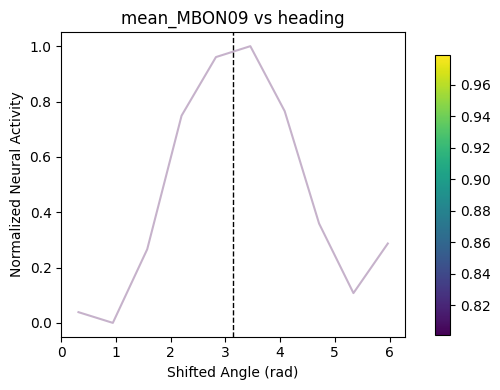

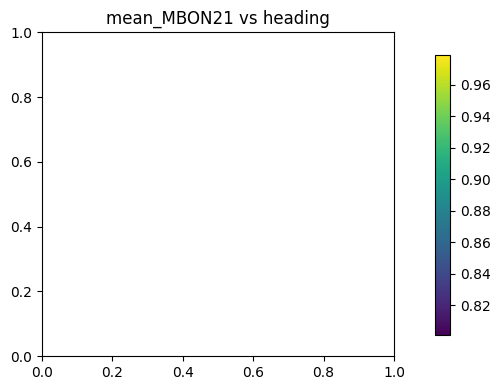

In [524]:
plot_tuning_curve_wrapper_3(test_filter_time, ["mean_MBON09", "mean_MBON21"], behavioral_vars=['heading'],  
                              num_bins=10, percentile_low=0, percentile_high=100, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=False)

##### Count trials

In [ ]:
# MBON09 unique flies
unique_flyids = combined_df.loc[combined_df['MBON09L'].notna() | combined_df['MBON09R'].notna(), 'flyid'].nunique()
print(unique_flyids)


In [ ]:
filtered_df = combined_df.loc[combined_df['MBON09L'].notna() | combined_df['MBON09R'].notna()]
total_trials = filtered_df.groupby('flyid')['trialid'].nunique().sum()
print(total_trials)


#### Examine no bar

In [302]:
#test_filter_netmotion = nobar_all[(nobar_all.fwV>0.4) | (nobar_all.fwV<-0.4)]
test_filter_netmotion = nobar_all[nobar_all.net_motion>5]
test_filter_odor = test_filter_netmotion[test_filter_netmotion.odor_state!=1]
test_filter_time = test_filter_odor[test_filter_odor.time>10]
test_filter_phase = test_filter_time[test_filter_time.phase.notna()]
#test_filter_phase = test_filter_phase[test_filter_phase.amplitude>1]

C:\Users\wilson\AppData\Local\Temp\ipykernel_5984\1910758970.py:1208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


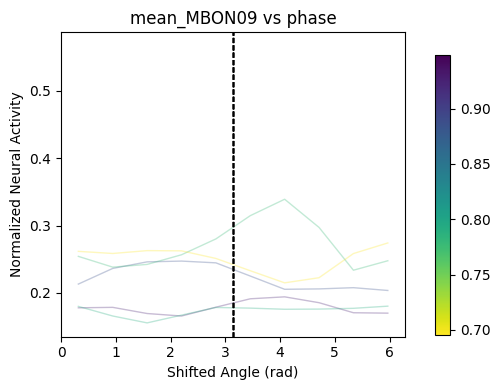

C:\Users\wilson\AppData\Local\Temp\ipykernel_5984\1910758970.py:1208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


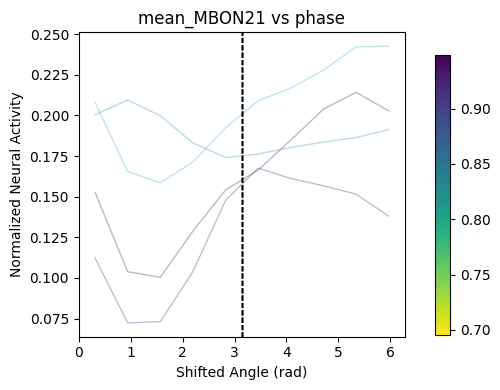

In [304]:
plot_tuning_curve_wrapper_3(test_filter_time, ["mean_MBON09", "mean_MBON21"], behavioral_vars=['phase'],  
                              num_bins=10, percentile_low=0, percentile_high=100, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,do_normalize=False)

#### Examine heading vs phase

In [245]:
with open('saved_data/MBON_tuning_old.pkl', 'rb') as f:
    MBON_tuning_df = pickle.load(f)



Note: good hDeltaB
- 20221027-1_hDeltaBMBON09_GCAMP7f_odor trial 1
- 20250219-4_MBON21hDeltaB_jump_fly2 trial 2

In [641]:
#test_filter_netmotion = MBON_tuning_df[(MBON_tuning_df.fwV>0.4) | (MBON_tuning_df.fwV<-0.4)]
test_filter_netmotion = dual_df_new[dual_df_new.fwV>1]
#test_filter_netmotion = dual_df_new[dual_df_new.net_motion>2]
#test_filter_odor = test_filter_netmotion[test_filter_netmotion.odor_state==0]
test_filter_time = test_filter_netmotion[test_filter_netmotion.time>20]
test_filter_phase = test_filter_time[test_filter_time.phase.notna()]
#test_filter_phase = test_filter_phase[test_filter_phase.amplitude>1]
# Create a transformed phase column that is 2*pi minus the original phase
test_filter_phase['phase_transformed'] = 2 * np.pi - test_filter_phase['phase']

# Ensure the values are within the range [0, 2π]
test_filter_phase['phase_transformed'] = np.mod(test_filter_phase['phase_transformed'], 2 * np.pi)

# Print a sample to verify the transformation
print("Original phase vs transformed phase (first 5 rows):")
print(test_filter_phase[['phase', 'phase_transformed']].head())



Original phase vs transformed phase (first 5 rows):
        phase  phase_transformed
98   4.178051           2.105134
173  4.582440           1.700746
174  4.444620           1.838565
175  4.271179           2.012006
176  4.195221           2.087964


In [642]:
test = test_filter_phase[(test_filter_phase['folder_name'] == '20250219-4_MBON21hDeltaB_jump_fly2') & (test_filter_phase['trialid'] == 2)]
#test = test_filter_phase

In [ ]:
key = 'mean_MBON21'
fig, ax = plt.subplots(3, 1, figsize=(8, 9))
idx1 = 0
idx2 = -1
ax[0].scatter(test.time[idx1:idx2], test.heading[idx1:idx2],color='orangered',alpha=0.5)
ax[1].scatter(test.time[idx1:idx2], test.phase[idx1:idx2],color='red',alpha=0.5)

#ax[2].plot(merged_df.time[idx1:idx2], merged_df['amplitude'][idx1:idx2],color='brown',alpha=0.5)

plt.show()

In [ ]:
plt.scatter(test.phase, test.heading,c=test.amplitude)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
imaging_behavior_functions_plotting.plot_scatter(test, 'phase', 'mean_MBON21', ax=ax, return_fig=False)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
imaging_behavior_functions_plotting.plot_scatter(test, 'heading', 'mean_MBON21', ax=ax, return_fig=False)

In [ ]:
plot_tuning_curve_wrapper_3(test, ["mean_MBON09", "mean_MBON21"], behavioral_vars=['heading'],  
                              num_bins=10, percentile_low=0, percentile_high=100, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,do_normalize=True)

#### Examine MBON09/21 heading tuning

In [3]:
with open('saved_data/MBON_tuning_old.pkl', 'rb') as f:
    MBON_tuning_df = pickle.load(f)



In [4]:
test_filter_netmotion = MBON_tuning_df[(MBON_tuning_df.fwV>0.4) | (MBON_tuning_df.fwV<-0.4)]
#test_filter_netmotion = nobar_all[nobar_all.net_motion>5]
test_filter_odor = test_filter_netmotion[test_filter_netmotion.odor_state!=1]
test_filter_time = test_filter_odor[test_filter_odor.time>10]


C:\Users\wilson\AppData\Local\Temp\ipykernel_4708\1338541070.py:783: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


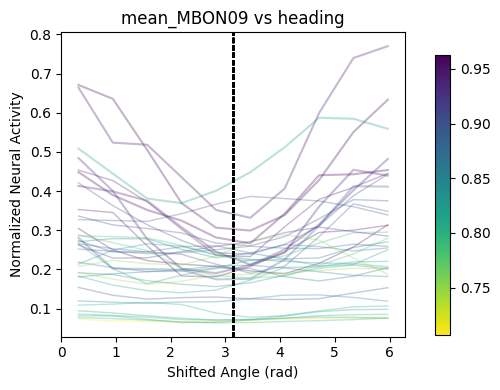

C:\Users\wilson\AppData\Local\Temp\ipykernel_4708\1338541070.py:783: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


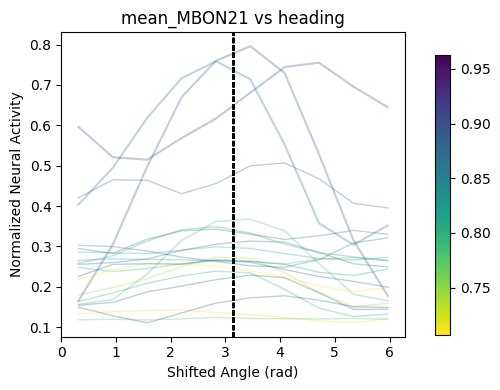

In [195]:
plot_tuning_curve_wrapper_3(test_filter_time, ["mean_MBON09", "mean_MBON21"], behavioral_vars=['heading'],  
                              num_bins=10, percentile_low=0, percentile_high=100, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,do_normalize=False)

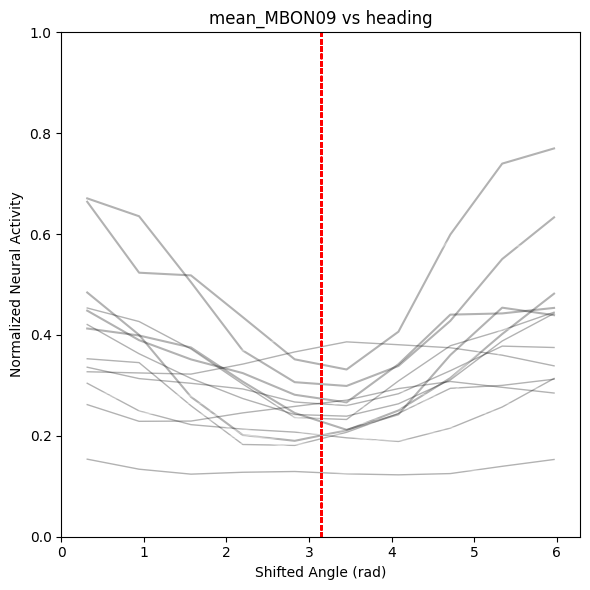

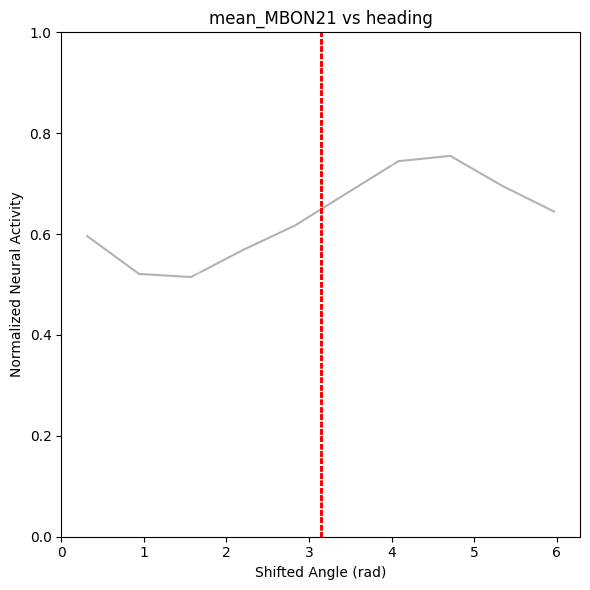

In [14]:
plot_tuning_curve_wrapper_4(test_filter_time, ["mean_MBON09", "mean_MBON21"], behavioral_vars=['heading'], 
                                num_bins=10, plot_column='rho_t', plot_var_func=None, apply_smoothing=True, do_normalize=False,
                                threshold_value=0.90, color_above_threshold='black', color_below_threshold='white')

In [16]:
MBON09_tuning_df = MBON_tuning_df[MBON_tuning_df['MBON09L'].notna() | MBON_tuning_df['MBON09R'].notna()]

In [21]:
# MBON09 unique flies
unique_flyids = MBON09_tuning_df.flyid.nunique()
print(unique_flyids)
total_trials = MBON09_tuning_df.groupby('flyid')['trialid'].nunique().sum()
print(total_trials)


23
36


In [17]:
MBON21_tuning_df = MBON_tuning_df[MBON_tuning_df['MBON21L'].notna() | MBON_tuning_df['MBON21R'].notna()]


In [142]:
# MBON09 unique flies
unique_flyids = MBON21_tuning_df.flyid.nunique()
print(unique_flyids)
total_trials = MBON21_tuning_df.groupby('flyid')['trialid'].nunique().sum()
print(total_trials)


9
20


In [155]:
MBON09_tuning_df.folder_name.unique()

array(['20220525-4_MBON09_GCAMP7f', '20220525-5_MBON09_GCAMP7f_fly2',
       '20220621-2_MBON09_GCAMP7f_short',
       '20220621-5_MBON09_GCAMP7f_long',
       '20220621-9_MBON09_GCAMP7f_fly2_long',
       '20220822-6_MBON0921_GCAMP7f_long',
       '20220913-8_MBON09hDeltaB_syntGCAMP7f_fly3_short',
       '20220913-9_MBON09hDeltaB_syntGCAMP7f_fly3_long',
       '20220922-12_MBON09_GCAMP7f_fly2_long',
       '20221006-3_MBON0921_GCAMP7f_odor_short',
       '20221027-1_hDeltaBMBON09_GCAMP7f_odor',
       '20230517-2_MBON09hDeltaB_syntGCAMP7f_long_nojump',
       '20230517-3_MBON09hDeltaB_syntGCAMP7f_long_jump',
       '20230522-2_MBON09_GCAMP7f_short_sparse_odor',
       '20230522-3_MBON09_GCAMP7f_short_ctns_odor',
       '20230522-4_MBON09_GCAMP7f_short_sparse_odor',
       '20230525-4_MBON09_GCAMP7f_short_odor',
       '20230529-3_MBON09_hDeltaB_syntGCAMP7f_odor',
       '20230608-4_MBON09hDeltaB_GCAMP7f_odor_short',
       '20230630-4_MBON09_GCAMP7f_odor_apple_long2',
       '20230817

In [183]:
MBON09_tuning_df_filt = MBON09_tuning_df[(MBON09_tuning_df['folder_name'] == '20221006-3_MBON0921_GCAMP7f_odor_short') & (MBON09_tuning_df['trialid'] ==  2)]

In [184]:
MBON09_tuning_df_filt.rho_t.unique()

array([       nan, 0.98347668, 0.98343955, ..., 0.93186823, 0.95374112,
       0.95138638])

(<Figure size 1000x1000 with 1 Axes>, <PolarAxes: >)

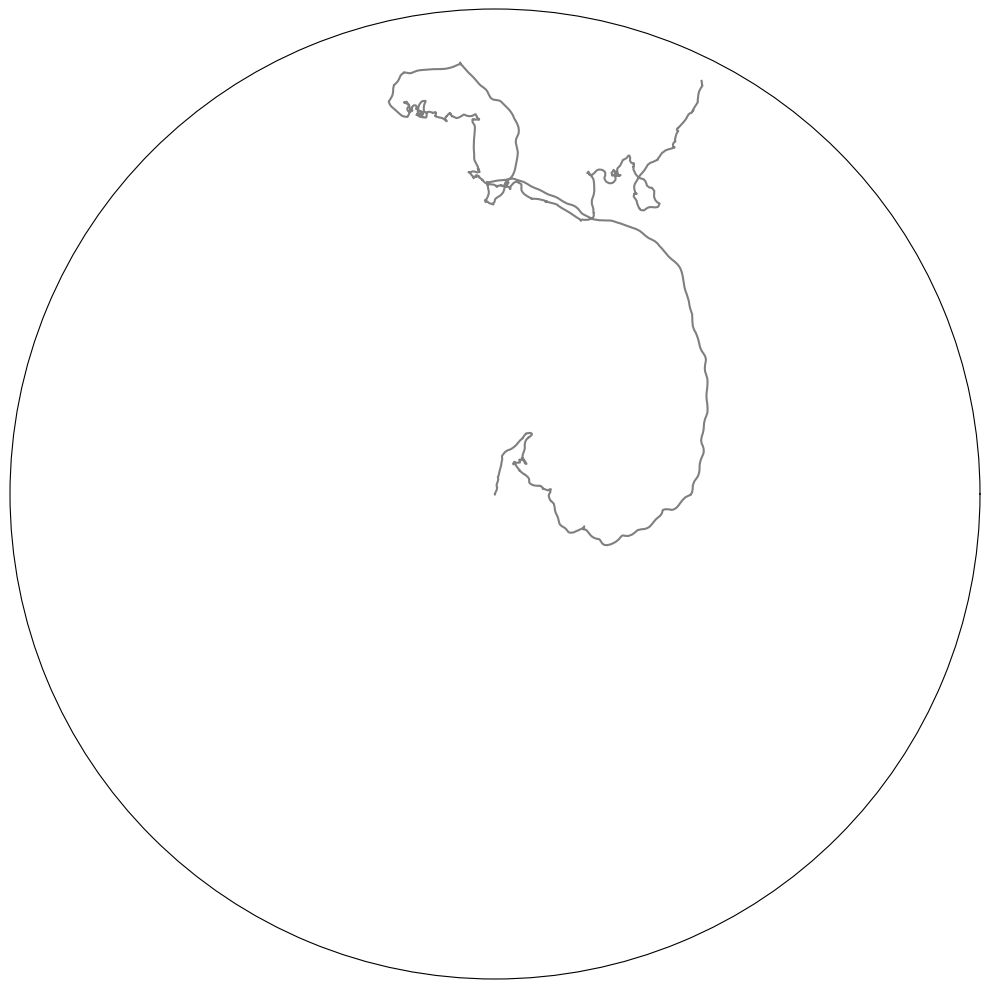

In [185]:
plot_fly_paths_polar(MBON09_tuning_df_filt, color_col=None, figsize=(10, 10))

#### examine hDeltaB

In [259]:
with open('saved_data/combined_old.pkl', 'rb') as f:
    combined_df_old = pickle.load(f)

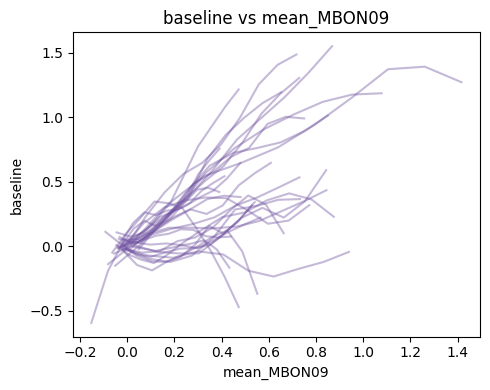

In [373]:
combined_df_filtered = combined_df_old[~((combined_df_old['folder_name'] == '20231107-1_MBON21_GCAMP7f_odor_5dur25isi') & (combined_df_old['trialid'] == 3))]
combined_df_copy = combined_df_filtered[combined_df_filtered.net_motion_state==1].copy()
# Create a copy of the dataframe with only unique flyid and trialid combinations
# where the average odor_state is greater than 0
# First, group by flyid and trialid to calculate average odor_state
avg_odor_state = combined_df_copy.groupby(['flyid', 'trialid'])['odor_state'].mean().reset_index()

# Filter for combinations where average odor_state > 0
valid_combinations = avg_odor_state[avg_odor_state['odor_state'] > 0]

# Create a boolean mask to filter the original dataframe
mask = combined_df_copy.apply(lambda row: ((row['flyid'], row['trialid']) in 
                                          zip(valid_combinations['flyid'], 
                                              valid_combinations['trialid'])), 
                             axis=1)

# Apply the mask to create the filtered copy
combined_df_odor = combined_df_copy[mask].copy()

#print(f"Original dataframe had {len(combined_df_filtered[combined_df_filtered.net_motion_state==1])} rows")
#print(f"Filtered dataframe has {len(combined_df_copy)} rows")
#print(f"Number of unique flyid-trialid combinations: {combined_df_copy.groupby(['flyid', 'trialid']).ngroups}")


plot_tuning_curve_wrapper_3(combined_df_copy, [ "baseline"], behavioral_vars=['mean_MBON09'],  
                              num_bins=10, percentile_low=1, percentile_high=100, 
                              plot_column=None, plot_var_func=None, apply_smoothing=True)

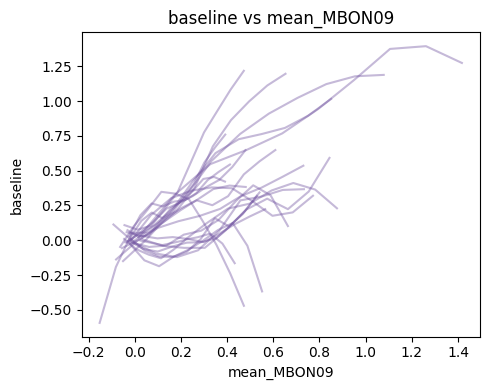

In [374]:
plot_tuning_curve_wrapper_3(combined_df_odor, [ "baseline"], behavioral_vars=['mean_MBON09'],  
                              num_bins=10, percentile_low=1, percentile_high=100, 
                              plot_column=None, plot_var_func=None, apply_smoothing=True)

Total trials with non-NaN mean_MBON09 and baseline: 30
Number of unique flyids: 20
Unique flyids: [ 23  24  27  30  56  57  66  67  68  74  93  94  95  96  97  98  99 100
 101 102]
Number of trials per flyid:
flyid
23     2
24     2
27     3
30     2
56     2
57     1
66     1
67     2
68     1
74     2
93     1
94     1
95     1
96     1
97     2
98     1
99     2
100    1
101    1
102    1
Name: trialid, dtype: int64


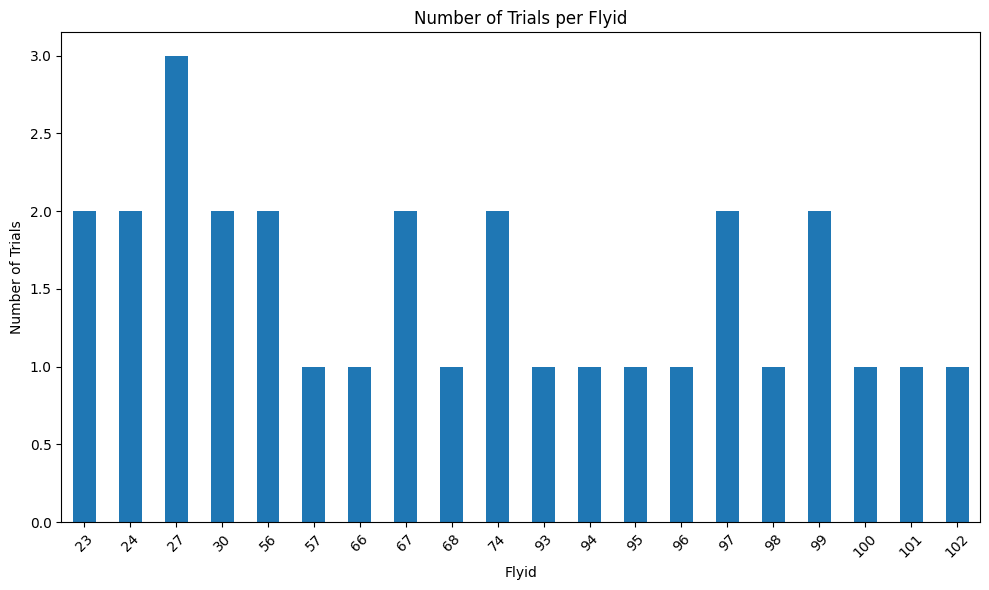

Total number of trials across all flyids: 30
Average number of trials per flyid: 1.50
Minimum number of trials for a flyid: 1
Maximum number of trials for a flyid: 3


In [371]:
#filtered_df = combined_df_filtered.loc[combined_df_filtered['MBON09L'].notna() | combined_df_filtered['MBON09R'].notna()]
#total_trials = filtered_df.groupby('flyid')['trialid'].nunique().sum()
#print(total_trials)
# Count number of trials for all flyids that have mean_MBON09 and baseline (not NaN)
filtered_df_MBON09 = combined_df_filtered.loc[combined_df_filtered['mean_MBON09'].notna() & combined_df_filtered['baseline'].notna()]
total_trials_MBON09 = filtered_df_MBON09.groupby('flyid')['trialid'].nunique().sum()
print(f"Total trials with non-NaN mean_MBON09 and baseline: {total_trials_MBON09}")

# Display the unique flyids that have both mean_MBON09 and baseline
unique_flyids = filtered_df_MBON09['flyid'].unique()
print(f"Number of unique flyids: {len(unique_flyids)}")
print("Unique flyids:", unique_flyids)
# Count the number of trials per flyid for MBON09 data
trials_per_flyid = filtered_df_MBON09.groupby('flyid')['trialid'].nunique()
print("Number of trials per flyid:")
print(trials_per_flyid)

# Create a bar plot to visualize the distribution of trials across flyids
plt.figure(figsize=(10, 6))
trials_per_flyid.plot(kind='bar')
plt.title('Number of Trials per Flyid')
plt.xlabel('Flyid')
plt.ylabel('Number of Trials')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate some statistics
total_trials = trials_per_flyid.sum()
avg_trials = trials_per_flyid.mean()
min_trials = trials_per_flyid.min()
max_trials = trials_per_flyid.max()

print(f"Total number of trials across all flyids: {total_trials}")
print(f"Average number of trials per flyid: {avg_trials:.2f}")
print(f"Minimum number of trials for a flyid: {min_trials}")
print(f"Maximum number of trials for a flyid: {max_trials}")




In [ ]:

def count_nonzero_avg_conditions(df,meancol = 'mean_MBON09'):
    """
    Count unique folder_name groups where the average of both
    'odor_state' and 'mean_MBON09' is nonzero.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        int: The count of folder_name groups meeting both conditions.
    """
    # Group by 'folder_name' and calculate the mean for each group
    group_means = df.groupby(['folder_name']).agg({
        'amplitude': 'mean',
        meancol: 'mean'
    })
    
    # Create a boolean mask for groups where both means are nonzero
    mask = (group_means['amplitude'] > 0) & (group_means[meancol] > 0)
    
    # Count and return the number of groups that satisfy both conditions
    return mask.sum()

# Example usage:
count = count_nonzero_avg_conditions(combined_df_filtered)
print(count)


### Examine FB4R

In [583]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/FB4R_imaging/filtered/"
FB4R_df_old = process_all_trials(base_path)

20230904-2_FB4R_syntGCAMP7f_sparsetime
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20230904-2_FB4R_syntGCAMP7f_sparsetime
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20230907-4_FB4R_syntGCAMP7f_sigmoid_flipaxis_fly2
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20230915-3_FB4R_syntGCAMP7f_sigmoid_flipaxis
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20230915-4_FB4R_syntGCAMP7f_sigmoid_flipaxis_flipsign
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON

In [20]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/new acquisition/filtered_FB4R/"
FB4R_df = process_all_trials_new(base_path)

20250122-2_FB4R_F12_jump
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20250122-3_FB4R_F12_odor_jump
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20250212-2_FB4R
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20250212-2_FB4R
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.


In [608]:
FB4R_all = pd.concat([FB4R_df_old, FB4R_df], ignore_index=True)



In [21]:
test_filter_netmotion = FB4R_df[(FB4R_df.fwV>1) | (FB4R_df.fwV<-0.4)]
#test_filter_netmotion = FB4R_df[FB4R_df.fwV>1]
#test_filter_netmotion = nobar_all[FB4R_df.FB4R_df>5]
test_filter_odor = test_filter_netmotion[test_filter_netmotion.odor_state!=1]
#test_filter_time = test_filter_netmotion[test_filter_netmotion.time>10]
#test_filter_phase = test_filter_time[test_filter_time.phase.notna()]
#test_filter_phase = test_filter_phase[test_filter_phase.amplitude>1]

In [616]:
#test = test_filter_time[(test_filter_time['folder_name'] == '20230907-3_FB4R_syntGCAMP7f_50secodor_fly2') & (test_filter_time['trialid'] == 1)]

C:\Users\wilson\AppData\Local\Temp\ipykernel_5984\1910758970.py:1208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


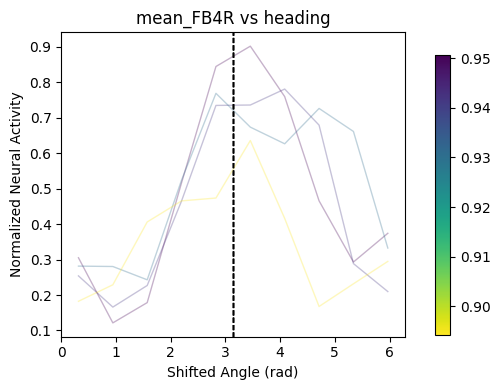

In [618]:
plot_tuning_curve_wrapper_3(test_filter_odor, ["mean_FB4R"], behavioral_vars=['heading'],  
                              num_bins=10, percentile_low=0, percentile_high=100, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,do_normalize=True)

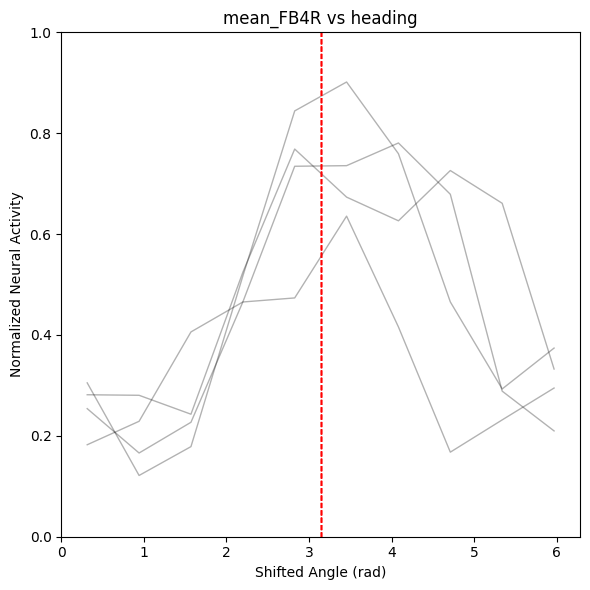

In [22]:
plot_tuning_curve_wrapper_4(test_filter_odor, ["mean_FB4R"], behavioral_vars=['heading'], 
                                num_bins=10, plot_column='rho_t', plot_var_func=None, apply_smoothing=True, do_normalize=True,
                                threshold_value=0.80, color_above_threshold='black', color_below_threshold='white')

### Examine FB5V

In [23]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/FB5V_imaging/"
FB5V_df = process_all_trials_new(base_path)

20250105-2_FB5V_nojump
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20250105-2_FB5V_nojump
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20250105-3_FB5V_jump
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20250105-3_FB5V_jump
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
20250105-3_FB5V_jump
Loaded using mat73.
Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in Da

In [24]:
#test_filter_netmotion = FB5V_df[(FB5V_df.fwV>1) | (FB5V_df.fwV<-0.4)]
test_filter_netmotion = FB5V_df[FB5V_df.fwV>2]
#test_filter_netmotion = nobar_all[FB4R_df.FB4R_df>5]
#test_filter_odor = test_filter_netmotion[test_filter_netmotion.odor_state!=1]

C:\Users\wilson\AppData\Local\Temp\ipykernel_5984\1910758970.py:1208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


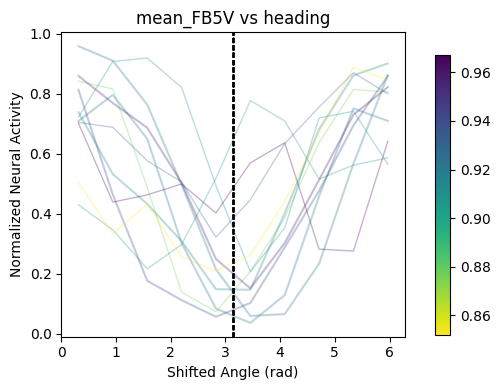

In [659]:
plot_tuning_curve_wrapper_3(test_filter_netmotion, ["mean_FB5V"], behavioral_vars=['heading'],  
                              num_bins=10, percentile_low=0, percentile_high=100, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,do_normalize=True)

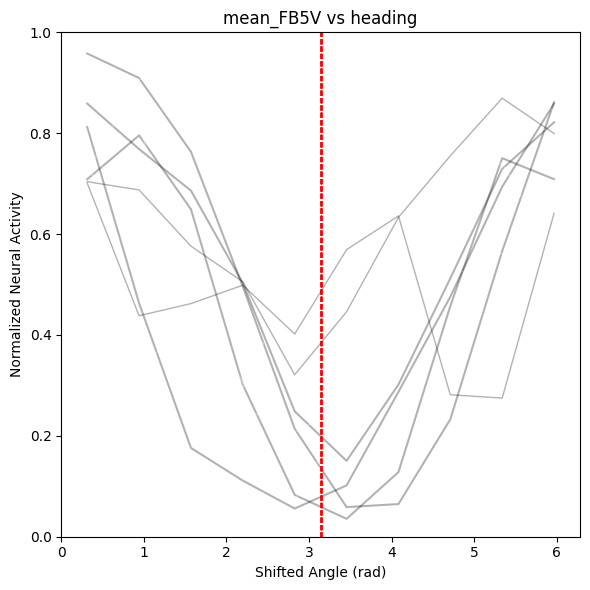

In [25]:
plot_tuning_curve_wrapper_4(test_filter_netmotion, ["mean_FB5V"], behavioral_vars=['heading'], 
                                num_bins=10, plot_column='rho_t', plot_var_func=None, apply_smoothing=True, do_normalize=True,
                                threshold_value=0.92, color_above_threshold='black', color_below_threshold='white')

### odor responses

#### MBON09/21 response colored by prior stimulus interval

In [979]:
combined_df_filtered = combined_df[~combined_df['folder_name'].str.contains("sigmoid", na=False)].reset_index(drop=True)

In [980]:

def count_nonzero_avg_conditions(df,meancol = 'mean_MBON09'):
    """
    Count unique folder_name groups where the average of both
    'odor_state' and 'mean_MBON09' is nonzero.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        int: The count of folder_name groups meeting both conditions.
    """
    # Group by 'folder_name' and calculate the mean for each group
    group_means = df.groupby(['folder_name','trialid']).agg({
        'odor_state': 'mean',
        meancol: 'mean'
    })
    
    # Create a boolean mask for groups where both means are nonzero
    mask = (group_means['odor_state'] != 0) & (group_means[meancol] > 0)
    
    # Count and return the number of groups that satisfy both conditions
    return mask.sum()

# Example usage:
count = count_nonzero_avg_conditions(combined_df_filtered)
print(count)


58


#### MBON09/21 response colored by novelty score

In [42]:
with open('saved_data/combined_new.pkl', 'rb') as f:
    combined_df_new = pickle.load(f)


In [377]:
with open('saved_data/combined_old.pkl', 'rb') as f:
    combined_df_old = pickle.load(f)



In [378]:
combined_df_filtered = combined_df_old[~combined_df_old['folder_name'].str.contains("sigmoid", na=False)].reset_index(drop=True)

(-10.0, 50.0)

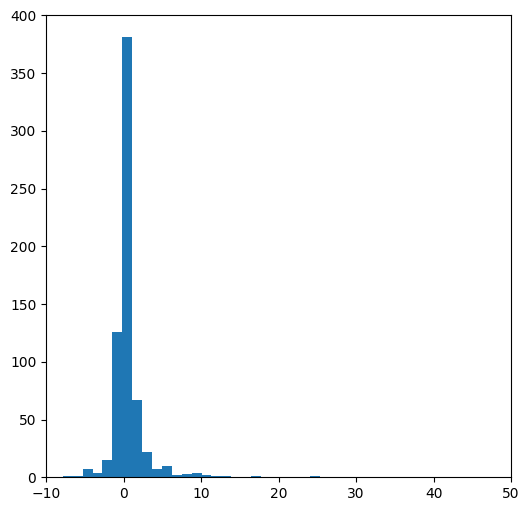

In [632]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(test.novelty_score,bins=200)
ax.set_xlim(-10,50)


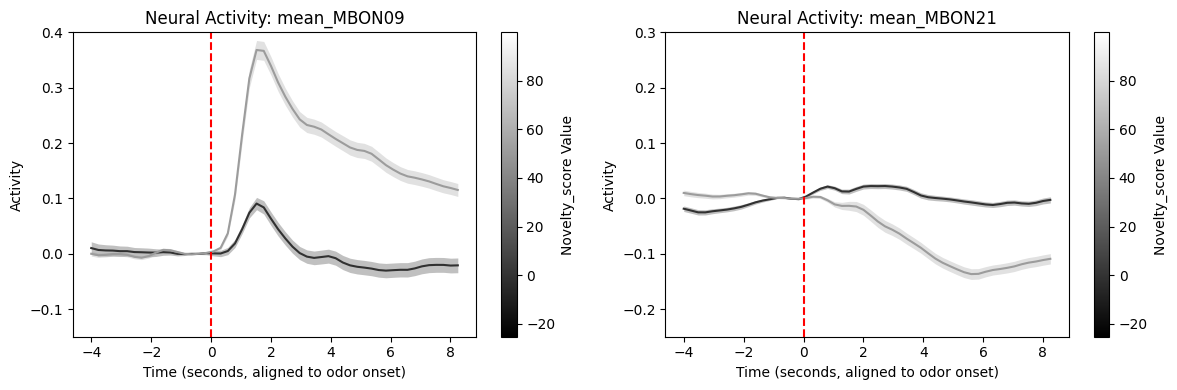

In [242]:
plot_neural_activity_zero(combined_df_filtered, plot_columns=["mean_MBON09","mean_MBON21"], pre_window_size=20, post_window_size=32,plot_kw = 'novelty_score',is_onset=True, bounds=[10],percentile_range=[1, 95],baseline_duration=1,onset_shift=0.8)

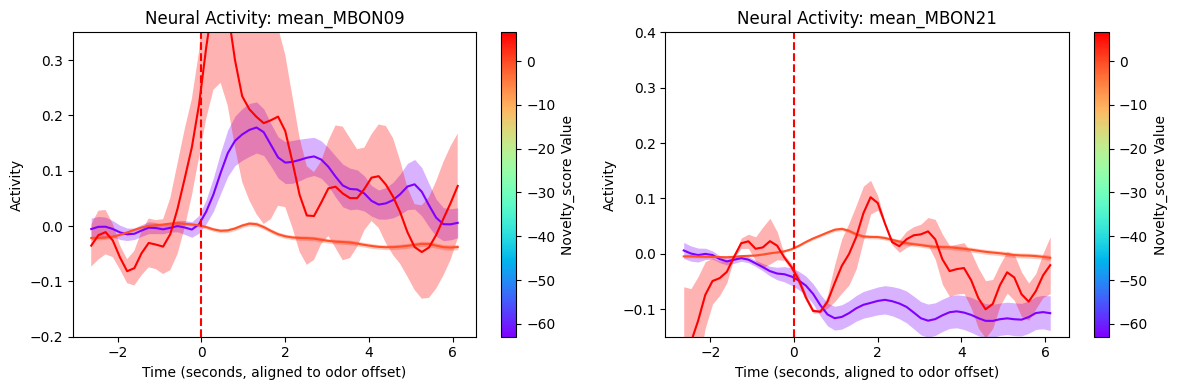

In [622]:
plot_neural_activity_zero(combined_df_new, plot_columns=["mean_MBON09","mean_MBON21"], pre_window_size=20, post_window_size=32,plot_kw = 'novelty_score',is_onset=False, bounds=[-30,30],percentile_range=[1, 98],baseline_duration=1,onset_shift=0.8)

#### FwV and yawV responses

In [379]:
events_df, agg_df = compute_event_stats(combined_df_filtered, prestim_window=(-20, 0), poststim_window=(0, 32), novelty_bins=[-50,0,30], yawV_bins=[0, 5, float('inf')])

C:\Users\wilson\AppData\Local\Temp\ipykernel_4708\105693339.py:697: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = events_df.groupby(['novelty_bin', 'fwV_bin', 'flyid'])


In [380]:
events_df

,onset_index,prestim_avg,poststim_avg,novelty_score,flyid,novelty_bin,fwV_bin
0,43603,0.395571,-0.064929,1.922855,11,"(0, 30]","(0.0, 5.0]"
1,43811,0.368988,0.772784,-22.112833,11,"(-50, 0]","(0.0, 5.0]"
2,44019,-0.043440,-0.126676,-22.112833,11,"(-50, 0]",NaN
3,44227,0.248614,-0.055274,-22.112833,11,"(-50, 0]","(0.0, 5.0]"
4,44435,-0.083854,-0.095671,-22.112833,11,"(-50, 0]",NaN
...,...,...,...,...,...,...,...
1064,426023,10.245648,6.205908,7.449631,111,"(0, 30]","(5.0, inf]"
1065,426211,5.447543,5.870435,7.689942,111,"(0, 30]","(5.0, inf]"
1066,426398,7.372216,5.408181,7.449631,111,"(0, 30]","(5.0, inf]"
1067,426585,10.668880,8.965290,7.449631,111,"(0, 30]","(5.0, inf]"


In [381]:
agg_df

,novelty_bin,fwV_bin,flyid,prestim_mean,prestim_se,poststim_mean,poststim_se,count
0,"(-50, 0]","(0.0, 5.0]",11,2.123186,0.397588,1.718644,0.385733,18
1,"(-50, 0]","(0.0, 5.0]",12,1.591887,0.465604,1.752597,0.225009,10
2,"(-50, 0]","(0.0, 5.0]",26,4.526753,NaN,6.772394,NaN,1
3,"(-50, 0]","(0.0, 5.0]",27,NaN,NaN,NaN,NaN,0
4,"(-50, 0]","(0.0, 5.0]",28,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
207,"(0, 30]","(5.0, inf]",107,NaN,NaN,NaN,NaN,0
208,"(0, 30]","(5.0, inf]",108,13.501321,0.645249,10.274946,0.841828,20
209,"(0, 30]","(5.0, inf]",109,7.111207,NaN,4.727896,NaN,1
210,"(0, 30]","(5.0, inf]",110,NaN,NaN,NaN,NaN,0


In [382]:

def plot_events_with_aggregate(events_df, agg_df, velocity_bin_left=0.5):
    """
    Overlays individual event data points with aggregated means and error bars.
    Only events from the highest velocity bin are used (i.e., events where fwV_bin has left bound equal to velocity_bin_left).
    The x-axis represents pre-stimulus (x=0) and post-stimulus (x=1) periods.
    Each novelty bin is represented with a unique color from the rainbow colormap.

    Parameters:
      events_df : pandas.DataFrame
          DataFrame containing individual event-level data with columns:
          'prestim_avg', 'poststim_avg', 'novelty_score', 'novelty_bin', and 'fwV_bin'.
      agg_df : pandas.DataFrame
          Aggregated DataFrame with columns: 'novelty_bin', 'fwV_bin',
          'prestim_mean', 'prestim_se', 'poststim_mean', 'poststim_se', and 'count'.
      velocity_bin_left : numeric (default=2)
          The left bound for filtering the velocity bin (e.g. 2 for [2, inf)).
    """
    # Filter for events in the highest velocity bin.
    events_highest = events_df[events_df['yawV_bin'].apply(lambda x: x.left == velocity_bin_left if hasattr(x, 'left') else False)]
    agg_highest = agg_df[agg_df['yawV_bin'].apply(lambda x: x.left == velocity_bin_left if hasattr(x, 'left') else False)]
    
    # Define a sorting key that handles both Interval objects and floats.
    def sort_key(x):
        return x.left if hasattr(x, 'left') else x
    
    # Get unique novelty bins and sort them.
    novelty_bins = sorted(events_highest['novelty_bin'].unique(), key=sort_key)
    
    # Define x positions: 0 for pre-stimulus and 1 for post-stimulus.
    x_positions = np.array([0, 1])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set up a rainbow colormap.
    n_bins = len(novelty_bins)
    cmap = plt.get_cmap('rainbow')
    
    # Loop over each novelty bin.
    for i, nb in enumerate(novelty_bins):
        color = cmap(i/(n_bins-1)) if n_bins > 1 else cmap(0.5)
        
        # Get the subset of events for this novelty bin.
        subset_events = events_highest[events_highest['novelty_bin'] == nb]
        
        # Scatter plot individual pre-stimulus and post-stimulus values with slight horizontal jitter.
        jitter_pre = np.random.normal(0, 0.03, size=len(subset_events))
        jitter_post = np.random.normal(0, 0.03, size=len(subset_events))
        ax.scatter(np.full(len(subset_events), 0) + jitter_pre,
                   subset_events['prestim_avg'],
                   color=color, alpha=0.6, s=30)
        ax.scatter(np.full(len(subset_events), 1) + jitter_post,
                   subset_events['poststim_avg'],
                   color=color, alpha=0.6, s=30)
        
        # Overlay aggregated mean and error bars for this novelty bin.
        agg_row = agg_highest[agg_highest['novelty_bin'] == nb]
        if not agg_row.empty:
            pre_mean = agg_row['prestim_mean'].values[0]
            pre_se = agg_row['prestim_se'].values[0]
            post_mean = agg_row['poststim_mean'].values[0]
            post_se = agg_row['poststim_se'].values[0]
            
            ax.errorbar(x_positions, [pre_mean, post_mean],
                        yerr=[pre_se, post_se],
                        color=color, marker='o', markersize=8, capsize=5,
                        label=str(nb))
    
    # Set up the x-axis and labels.
    ax.set_xticks(x_positions)
    ax.set_xticklabels(['Pre-stimulus', 'Post-stimulus'])
    ax.set_ylabel('Mean fwV')
    ax.set_title('Individual Event fwV with Aggregated Means and Error Bars\n(Highest Velocity Bin by Novelty Bin)')
    
    # Place the legend outside the plot for clarity.
    ax.legend(title='Novelty Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_events_with_aggregate(events_df, agg_df)


KeyError: 'yawV_bin'

7.64694204354954e-08


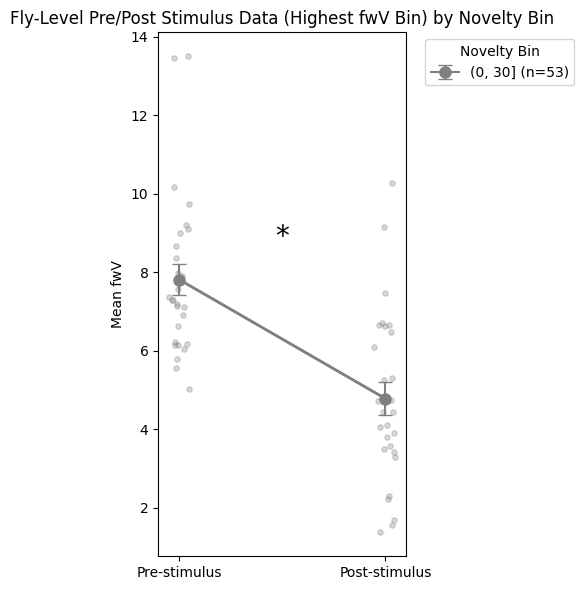

In [383]:

from scipy.stats import ttest_rel

import numpy as np
from scipy.stats import ttest_rel

def calc_poststim_significance(pre_vals, post_vals, alpha=0.05, alternative="greater"):
    """
    Performs a one-tailed paired t-test to determine if the poststimulus mean is significantly
    different from the prestimulus mean in a specified direction.

    Parameters:
      pre_vals (array-like): Array of prestimulus measurements.
      post_vals (array-like): Array of poststimulus measurements.
      alpha (float): Significance level for the test (default is 0.05).
      alternative (str): Specifies the alternative hypothesis:
                         "greater" tests if poststimulus is significantly higher than prestimulus (default),
                         "less" tests if poststimulus is significantly lower than prestimulus.

    Returns:
      t_stat (float): The computed t statistic.
      p_value (float): The one-tailed p-value.
      significant (bool): True if the test meets significance criteria (p_value < alpha), False otherwise.

    Notes:
      - NaN values are removed in a paired fashion.
      - The scipy.stats.ttest_rel function returns a two-tailed p-value.
      - For the "greater" alternative:
            If t_stat > 0, one-tailed p-value = p_two / 2.
            Otherwise, one-tailed p-value = 1 - p_two / 2.
      - For the "less" alternative:
            If t_stat < 0, one-tailed p-value = p_two / 2.
            Otherwise, one-tailed p-value = 1 - p_two / 2.
    """
    if alternative not in ["greater", "less"]:
        raise ValueError("alternative must be 'greater' or 'less'")
    
    # Convert inputs to numpy arrays and remove NaN pairs.
    pre_vals = np.array(pre_vals)
    post_vals = np.array(post_vals)
    valid = ~np.isnan(pre_vals) & ~np.isnan(post_vals)
    pre_vals = pre_vals[valid]
    post_vals = post_vals[valid]
    
    # Check if there is enough data to perform the test.
    if len(pre_vals) < 2:
        return np.nan, np.nan, False
    
    # Perform the paired t-test (post vs. pre).
    t_stat, p_two = ttest_rel(post_vals, pre_vals)
    
    # Calculate one-tailed p-value based on the alternative hypothesis.
    if alternative == "greater":
        if t_stat > 0:
            p_one = p_two / 2.0
        else:
            p_one = 1 - (p_two / 2.0)
    elif alternative == "less":
        if t_stat < 0:
            p_one = p_two / 2.0
        else:
            p_one = 1 - (p_two / 2.0)
    
    significant = p_one < alpha
    return t_stat, p_one, significant


def plot_agg_flylevel_with_line(agg_df,ball_d = 9):
    """
    Using the aggregated DataFrame (agg_df) that contains one row per fly for each novelty_bin and fwV_bin,
    this function filters for the highest fwV_bin (assumed here to be the bin with right bound equal to infinity)
    and, for each novelty_bin, plots:
      - Individual fly-level data as scatter points (at x=0 for pre-stimulus and x=1 for post-stimulus) with jitter.
      - An overlaid aggregated average (with error bars) and a connecting line between pre- and post-stimulus values.
    
    The agg_df is assumed to contain the following columns:
      'novelty_bin', 'fwV_bin', 'flyid', 'prestim_mean', 'prestim_se', 
      'poststim_mean', 'poststim_se', and 'count'.
      
    Note: When calculating mean and standard error, NaNs are removed first.
    """
    # Filter for the highest fwV_bin (assuming fwV_bin is an Interval and the highest bin has right bound = inf).
    highest_df = agg_df[agg_df['fwV_bin'].apply(lambda x: hasattr(x, 'right') and x.right == float('inf'))]
    
    # Get unique novelty bins from the filtered data.
    novelty_bins = highest_df['novelty_bin'].unique()
    
    cmap = plt.get_cmap('rainbow')
    n_bins = len(novelty_bins)
    colors = ['gray']
    fig, ax = plt.subplots(figsize=(5, 6))
    
    # Define x positions: 0 for pre-stimulus and 1 for post-stimulus.
    x_positions = np.array([0, 1])
    
    for i, nb in enumerate(novelty_bins[1:]):
        #color = cmap(i/(2*n_bins-1)) if n_bins > 1 else cmap(0.5)
        color = colors[i]
        
        # Filter rows for this novelty bin.
        data = highest_df[highest_df['novelty_bin'] == nb]
        #print(data)
        
        # Plot individual fly-level data points with a small horizontal jitter.
        jitter_pre = np.random.normal(0, 0.03, size=len(data))
        jitter_post = np.random.normal(0, 0.03, size=len(data))
        ax.scatter(np.full(len(data), 0) + jitter_pre, data['prestim_mean'],
                   color=color, alpha=0.3, s=15)
        ax.scatter(np.full(len(data), 1) + jitter_post, data['poststim_mean'],
                   color=color, alpha=0.3, s=15)
        
        # Remove NaNs before computing aggregated statistics.
        pre_vals = data['prestim_mean'].dropna().values
        post_vals = data['poststim_mean'].dropna().values
        # Calculate significance for pre vs. post.
        t_stat, p_value, significant = calc_poststim_significance(pre_vals, post_vals,alternative="less")
        print(p_value)
        
        if len(pre_vals) > 0:
            mean_pre = np.mean(pre_vals)#*ball_d/2
            se_pre = np.std(pre_vals, ddof=1) / np.sqrt(len(pre_vals)) if len(pre_vals) > 1 else 0
            se_pre = se_pre#*ball_d/2
        else:
            mean_pre, se_pre = np.nan, np.nan
            
        if len(post_vals) > 0:
            mean_post = np.mean(post_vals)#*ball_d/2
            se_post = np.std(post_vals, ddof=1) / np.sqrt(len(post_vals)) if len(post_vals) > 1 else 0
            se_post = se_post#*ball_d/2
        else:
            mean_post, se_post = np.nan, np.nan
        
        # Plot a line connecting the aggregated means.
        ax.plot(x_positions, [mean_pre, mean_post], color=color, linewidth=2)
        
        # Overlay aggregated means with error bars.
        ax.errorbar(x_positions, [mean_pre, mean_post],
                    yerr=[se_pre, se_post],
                    color=color, marker='o', markersize=8, capsize=5,
                    label=f"{str(nb)} (n={len(data)})")
        if significant:
            # Place a significance star between the two means (customize the coordinates as needed)
            star_x = 0.5
            star_y = max(mean_pre + se_pre, mean_post + se_post) + 0.5  # adjust vertical position as needed
            ax.text(star_x, star_y, '*', fontsize=20, ha='center')
            
            ax.set_xticks(x_positions)
    #ax.set_ylim([0.5,9])
    ax.set_xticklabels(['Pre-stimulus', 'Post-stimulus'])
    ax.set_ylabel('Mean fwV')
    ax.set_title('Fly-Level Pre/Post Stimulus Data (Highest fwV Bin) by Novelty Bin')
    ax.legend(title='Novelty Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_agg_flylevel_with_line(agg_df)


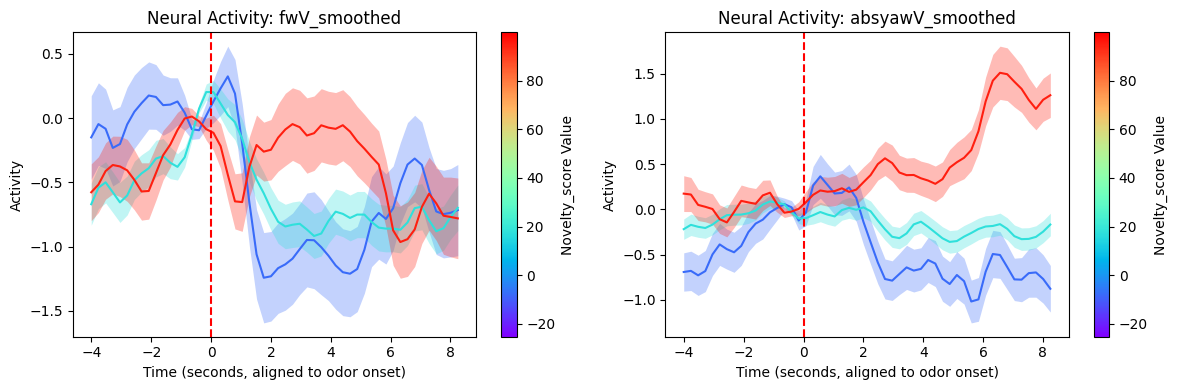

In [91]:
plot_neural_activity_zero(combined_df_filtered, plot_columns=["fwV", "absyawV"],sigma = 1,pre_window_size=20, post_window_size=32,plot_kw = 'novelty_score',is_onset=True, bounds=[0,50],percentile_range=[1, 95],baseline_duration=1,onset_shift=0.8)

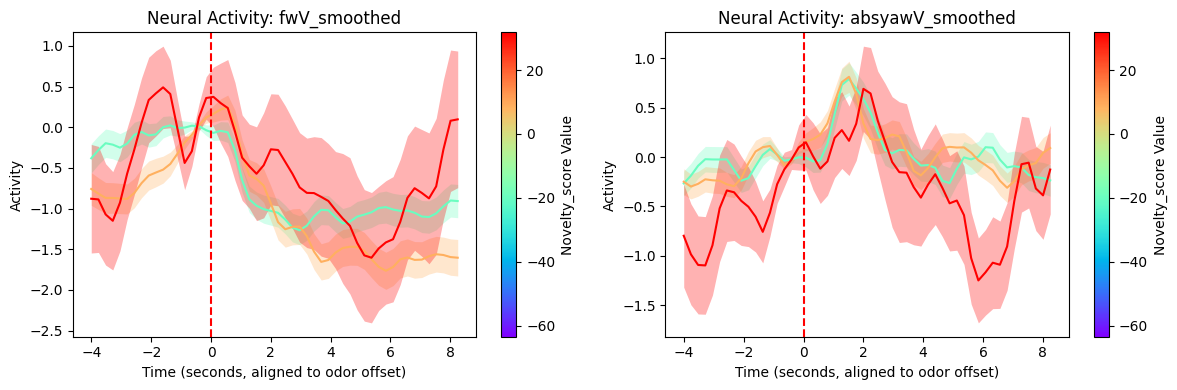

In [103]:
plot_neural_activity_zero(combined_df_filtered, plot_columns=["fwV", "absyawV"],sigma = 1,pre_window_size=20, post_window_size=32,plot_kw = 'novelty_score',is_onset=False, bounds=[0,50],percentile_range=[1, 95],baseline_duration=1,onset_shift=0.8)

### DANs

In [987]:
DAN_df.folder_name.unique()

array(['20211228-5_20211228_MB441B_age1',
       '20220525-8_MB312C_GCAMP7f_fly2', '20220525-9_MB312C_GCAMP7f_fly2',
       '20220607-5_MB312C_GCAMP7f_fly2', '20220607-7_MB312C_GCAMP7f_fly2',
       '20220608-9_MB312C_GCAMP7f', '20220616-2_MB441B_GCAMP7f_short',
       '20220616-3_MB441B_GCAMP7f_long',
       '20220628-2_MB441B_GCAMP7f_short',
       '20220628-3_MB441B_GCAMP7f_long'], dtype=object)

In [29]:
test_filter_netmotion = DAN_df[DAN_df.fwV>2]
#test_filter_netmotion = nobar_all[FB4R_df.FB4R_df>5]
#test_filter_odor = test_filter_netmotion[test_filter_netmotion.odor_state!=1]

C:\Users\wilson\AppData\Local\Temp\ipykernel_4708\1886985746.py:877: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


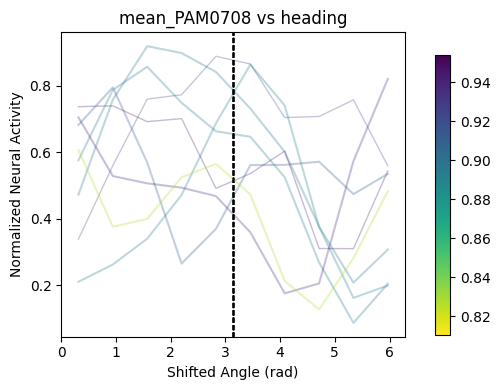

C:\Users\wilson\AppData\Local\Temp\ipykernel_4708\1886985746.py:877: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


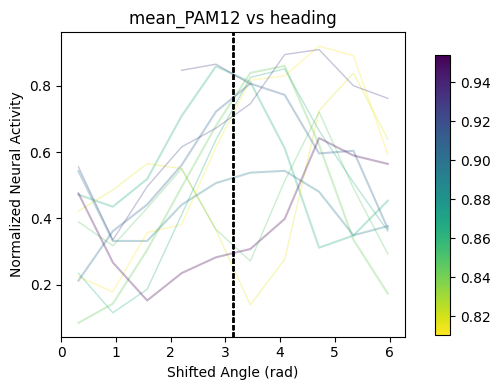

In [35]:

plot_tuning_curve_wrapper_3(test_filter_netmotion, ["mean_PAM0708", "mean_PAM12"], behavioral_vars=['heading'],  
                              num_bins=10, percentile_low=0, percentile_high=100, 
                              plot_column='rho_t', plot_var_func=None, apply_smoothing=True,do_normalize=True)

In [ ]:

def count_nonzero_avg_conditions(df,meancol = 'mean_PAM12'):
    """
    Count unique folder_name groups where the average of both
    'odor_state' and 'mean_MBON09' is nonzero.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        int: The count of folder_name groups meeting both conditions.
    """
    # Group by 'folder_name' and calculate the mean for each group
    group_means = df.groupby(['folder_name']).agg({
        'absyawV': 'mean',
        meancol: 'mean'
    })
    
    # Create a boolean mask for groups where both means are nonzero
    mask = (group_means['absyawV'] > 0) & (group_means[meancol] > 0)
    
    # Count and return the number of groups that satisfy both conditions
    return mask.sum()

# Example usage:
count = count_nonzero_avg_conditions(combined_df_DAN)
print(count)
